# **Comparing Preprocessing Methods of Textual Data for Semantic Analysis in Stock Trend Predictions**

## **Abstract**

This paper presents a novel approach to predicting stock trends using textual data from a large corpus named "all-the-news-2-1." Articles related to finance were filtered and categorized into four groups: General, APPL, NTFX, and AMZN, based on their relevance to specific stocks. The text data underwent preprocessing steps including lemmatization and removal of stopwords. Three distinct preprocessing methods—Part-of-Speech (POS) tagging, Bigrams, and Word Embeddings (WE)—were applied to the title and article columns, followed by sentiment analysis. Financial parameters were integrated with the processed textual data, and each unique dataset (POS, Bigrams, WE) was used to train Long Short-Term Memory (LSTM) models. The input for the LSTM models consisted of a 5-day rolling window containing 20 randomly selected articles per day, with padding applied as necessary. The output was the predicted stock trend for the fifth day. This approach aims to compare the effectiveness of the three preprocessing methods in enhancing stock trend prediction, demonstrating the potential of combining textual sentiment analysis and financial metrics.


## **Introduction**

Natural Language Processing (NLP), a fast-growing branch of artificial intelligence, is changing the way machines understand human communication. From extracting emotions in text to identifying complex patterns in language, NLP equips computers with the ability to read and interpret information just like people do. This capability opens new doors in industries that rely heavily on language — and finance is one of them.

Trading has transformed dramatically in recent years. What was once driven by instinct and human timing has evolved into fully automated systems executing trades in milliseconds. Algorithmic trading uses models that analyze charts, numbers, and financial indicators to make precise decisions and capitalize on even the smallest market fluctuations. Today’s models rely not only on historical data, but also on a variety of tools developed by economists — like financial indices and traditional metrics — to guide decisions.

But as trading becomes more competitive and data-driven, algorithms need more than just numbers to stay ahead. Financial markets are shaped not only by indicators but also by the moods, fears, and expectations of investors. Since no model can access the internal thoughts of traders or institutions, the next best thing is to analyze the digital trail they leave behind — in the form of financial reports, news articles, social media posts, and blogs. These sources provide rich insights into investor sentiment and market psychology.

This is where NLP meets algorithmic trading. By combining textual analysis with powerful machine learning models like KNN, Random Forest, SVM, CNN, RNN, LSTM, Bayesian networks, and Transformers, researchers are building systems that can detect market sentiment, forecast trends, and even outperform traditional strategies. The ability to incorporate language-based data has opened up new possibilities in predicting short-term movements and long-term patterns in the market.

NLP tools are gaining momentum in this space because they allow us to revisit the past — earnings reports, press releases, even opinion pieces — and reframe them as structured signals for modern prediction models. This unlocks a deeper layer of market insight, turning raw text into actionable knowledge. However, building such models requires careful planning and execution: collecting and cleaning data, extracting meaningful features, selecting and training the right models, evaluating them thoroughly, and analyzing the results.

In a sea of unstructured information, how you prepare the data makes all the difference. Text preprocessing — like lemmatization, removing irrelevant words, detecting parts of speech, or generating word embeddings — is not just a technical step, it’s a strategic one. The better the preprocessing pipeline, the clearer the signal the model can learn from. That’s why this project focused on comparing multiple preprocessing strategies to identify which ones truly unlock the predictive power of language in finance — and help make smarter trading decisions.

The prediction of stock trends remains a high-stakes task in the financial world. With the right combination of traditional financial data and cutting-edge NLP techniques, it's now possible to create more accurate, forward-looking models that offer real value to investors, analysts, and decision-makers alike.

## Setting requirements

### Pip, Imports and constants 

In [ ]:
%%capture
# Install Dask or PyArrow for large dataset handling (optional)
%pip install dask pyarrow.

# Install TensorFlow and Keras for LSTM
%pip install tensorflow

# Install Hugging Face Transformers for FinBERT
%pip install transformers

# Install Torch for FinBERT model
%pip install torch

# Install NumPy and Pandas for data manipulation
%pip install numpy pandas

# Install Scikit-learn for data preprocessing and evaluation metrics
%pip install scikit-learn

# Install Matplotlib and Seaborn for data visualization
%pip install matplotlib seaborn

# Install Jupyter Notebook extensions (optional, for enhanced notebook features)
%pip install jupyter_contrib_nbextensions

# Install NLTK for text processing
%pip install nltk

# Install yfinance for stock data
%pip install yfinance

# Ensure TensorFlow is installed
%pip install tensorflow

# Install pandas_market_calendars for market calendars
%pip install pandas-market-calendars

# install wordcloud for word cloud visualization
%pip install wordcloud

# install scipy for scientific computing
%pip install scipy==1.10.1

# install gensim for word2vec
%pip install gensim

# install pandas_datareader for stock data
%pip install pandas_datareader

%pip install --upgrade typing_extensions

In [1]:
%%capture
# Import necessary libraries for the project
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('all')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import gensim
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
IMPORT_FILES = True
TEST = False

### Textual Data

#### all-the-news-2-1 

This study leverages a comprehensive corpus of news articles, "all-the-news-2-1," to explore the impact of textual data on stock trend prediction. The corpus was filtered to extract articles related to finance and categorized into four groups: General, APPL, NTFX, and AMZN. Preprocessing steps, including lemmatization and removal of stopwords, were applied to the title and article columns to standardize the text. Three different preprocessing techniques—POS tagging, Bigrams, and WE—were employed to capture various linguistic features. Sentiment scores were calculated for both the title and article columns to quantify the emotional tone of the text.

To integrate textual data with traditional financial metrics, the processed datasets were combined with relevant financial parameters. Each unique dataset (POS, Bigrams, WE) was then used to train LSTM models, which are well-suited for sequential data analysis. The input for the LSTM models consisted of a 5-day rolling window of 20 randomly selected articles per day, with padding applied as necessary to handle varying article counts. The models aimed to predict the stock trend for the fifth day, providing a forward-looking perspective based on both textual sentiment and financial data.

This study highlights the potential of NLP techniques in enhancing stock trend prediction and underscores the importance of integrating diverse data sources for more accurate forecasting.

In [ ]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and filter dataset in one shot
file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/all-the-news-2-1.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}.")

# Read only needed columns initially to save memory
use_cols = ['title', 'article', 'year', 'month', 'day', 'publication', 'url', 'author', 'section']
news_df = pd.read_csv(file_path, usecols=use_cols, low_memory=False)

# Build date column and filter by range
news_df['Date'] = pd.to_datetime(news_df[['year', 'month', 'day']], errors='coerce')
filtered_news = news_df.loc[
    (news_df['Date'] >= "2016-01-01") & (news_df['Date'] <= "2020-04-02")
].drop(columns=['year', 'month', 'day'])  # Drop early

# 2. Clean data (in place) using chained one-liners
filtered_news.dropna(subset=['title', 'article', 'Date'], inplace=True)
filtered_news.drop_duplicates(inplace=True)
filtered_news.drop_duplicates(subset='title', keep='first', inplace=True)
filtered_news.drop(columns=['author', 'url', 'section', 'publication'], inplace=True)

# 3. Log row reduction
print(f"Remaining rows: {len(filtered_news)}")
_ = gc.collect()

# 4. Plot remaining columns only
def plot_columns(data):
    fig, axes = plt.subplots(1, len(data.columns), figsize=(6 * len(data.columns), 4))
    axes = axes if len(data.columns) > 1 else [axes]
    
    for ax, col in zip(axes, data.columns):
        unique = data[col].nunique()
        missing = data[col].isnull().mean() * 100
        if pd.api.types.is_numeric_dtype(data[col]):
            sns.histplot(data[col].dropna(), bins=30, ax=ax)
            ax.set_title(f"{col} | Unique: {unique}, Missing: {missing:.2f}%")
        else:
            dupes, nulls = data.duplicated(subset=[col]).sum(), data[col].isnull().sum()
            sns.barplot(x=["Duplications", "Missing"], y=[dupes, nulls], ax=ax)
            ax.set_title(f"{col} | Duplications & Missing")
        ax.set_ylabel(col)
        ax.set_xlabel("Count")
    
    plt.tight_layout()
    plt.show()

plot_columns(filtered_news)

#### plotting visualization of count duplicates and missing values ​​in news data set
Non-financial titles are excluded; 2020 has fewer entries, and article volume peaks month-end. We drop irrelevant columns, remove missing/duplicate rows, and keep only the first title occurrence.
### Data cleaning 
### Creating Financial News Data
To ensure that the dataset focuses strictly on financially relevant content, we applied a keyword-based filtering process. A curated list of financial terms—including stock tickers (e.g., AAPL, AMZN, NFLX), company names, financial indicators, and economic terminology—was used to construct a regular expression pattern. Articles were initially selected if either the title or the body contained at least one of these keywords. To further refine the dataset and improve content relevance, a stricter filter was applied, retaining only those entries where both the title and the article contained at least one financial keyword. This dual-condition filtering helps ensure that the remaining data is truly centered around financial topics, which is critical for downstream modeling tasks such as sentiment analysis and trend forecasting. For preview purposes, the top entries were truncated to display just the beginning of the title and article fields, offering a quick glimpse into the dataset's contents without overwhelming detail.

#### Categorizing Financial News Articles
To enhance the structure and interpretability of the dataset, each article was categorized based on its financial relevance to specific companies. A new column, Ticker, was initialized with the default label "General". We defined keyword groups for three primary stocks—AAPL, AMZN, and NFLX—alongside a broader General category for terms related to the overall financial market. The categorization function evaluated each article by examining both its title and content (converted to lowercase for case-insensitive matching). The logic prioritized the title: if a company-specific keyword was found there, the article was immediately tagged with that company’s ticker. If no match was found in the title, the article body was checked next. This method ensures that articles are associated with the most relevant financial entity, helping downstream tasks like company-specific sentiment analysis and trend prediction remain more focused and accurate. General 80564 AMZN 41937 AAPL 31815 NFLX 11049

In [ ]:
import pandas as pd

# Define keyword groups for classification
keywords_by_ticker = {
    'AAPL': ['AAPL', 'Apple', 'Apple Inc.', 'iPhone', 'MacBook', 'iPad', 'Apple stock'],
    'AMZN': ['AMZN', 'Amazon', 'Amazon Inc.', 'AWS', 'Prime', 'Amazon stock'],
    'NFLX': ['NFLX', 'Netflix', 'Netflix Originals', 'Streaming', 'Netflix stock'],
    'General': [
        'stock', 'stocks', 'shares', 'equity', 'price movement', 'market trends',
        'bull market', 'bear market', 'market volatility', 'earnings report',
        'quarterly results', 'forecast', 'valuation', 'trading volume', 'short squeeze',
        'revenue', 'profits', 'losses', 'dividends', 'growth', 'inflation',
        'recession', 'GDP', 'interest rates', 'policy changes'
    ]
}

# Flatten all keywords for filtering step
all_keywords = [kw for group in keywords_by_ticker.values() for kw in group]
keyword_pattern = '|'.join(all_keywords)

# Combined filtering and categorization
def filter_and_categorize(row):
    title = row.get('title', '').lower()
    article = row.get('article', '').lower()

    if not any(kw.lower() in title for kw in all_keywords): return None
    if not any(kw.lower() in article for kw in all_keywords): return None

    for ticker, kw_list in keywords_by_ticker.items():
        if ticker != 'General' and any(kw.lower() in title for kw in kw_list):
            return ticker
    for ticker, kw_list in keywords_by_ticker.items():
        if ticker != 'General' and any(kw.lower() in article for kw in kw_list):
            return ticker
    return 'General'

# Apply the filtering + categorization in one go
filtered_news['Ticker'] = filtered_news.apply(filter_and_categorize, axis=1)
filtered_news = filtered_news[filtered_news['Ticker'].notna()].copy()

##### Aligning News Data with NYSE Trading Calendar

To ensure our dataset accurately reflects real-world trading activity, we utilized the pandas_market_calendars library—an uncommon but highly effective tool for financial time series alignment. We specifically used the NYSE (New York Stock Exchange) calendar via mcal.get_calendar('NYSE') to retrieve the full list of valid trading days between January 1, 2016, and January 1, 2021. This step is crucial because financial news often includes dates when the stock market is closed, such as weekends and holidays. Without filtering for actual trading days, we risk misinterpreting gaps or inconsistencies in the time series as missing data when in fact, the market simply wasn't open. By aligning our data to this calendar, we could identify true missing days where no articles were published, rather than mistakenly counting non-trading days as data gaps. After removing timezone metadata for compatibility, we reindexed our grouped dataset to match the exact sequence of NYSE trading days, inserting zeros where articles were absent. This created a consistent time series that aligns perfectly with the operational days of the market—an essential foundation for any time-dependent modeling like LSTM or other financial forecasting approaches.

Filtered news date range: 2016-01-01 00:00:00 to 2020-04-01 00:00:00
Number of days with zero articles for at least one ticker: 26
AAPL - Days below Avg: 656, Days below Median: 506, Min: 0, Max: 143
AMZN - Days below Avg: 626, Days below Median: 521, Min: 0, Max: 138
General - Days below Avg: 559, Days below Median: 533, Min: 0, Max: 150
NFLX - Days below Avg: 657, Days below Median: 500, Min: 0, Max: 50


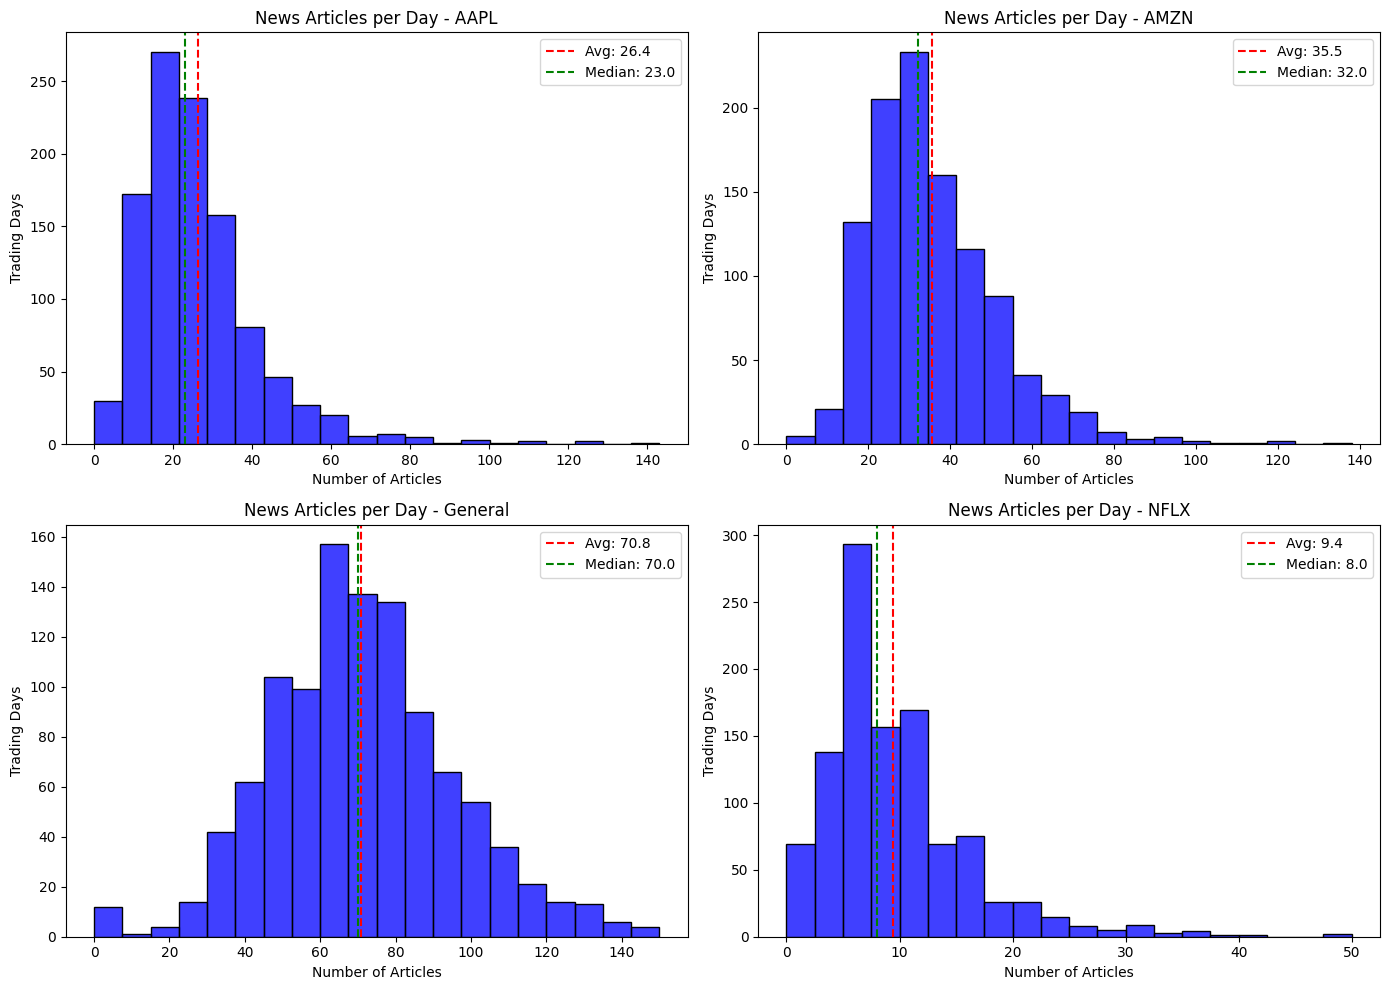

In [ ]:
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Define the NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Define date range
start_date = "2016-01-01"
end_date = "2020-04-02"

# Convert 'Date' column to datetime format
filtered_news['Date'] = pd.to_datetime(filtered_news['Date'])

# Group by 'Date' and 'Ticker' to count articles per day per stock
news_counts = filtered_news.groupby(['Date', 'Ticker']).size().unstack(fill_value=0)

# Get valid trading days from the NYSE calendar
trading_days = pd.to_datetime(nyse.valid_days(start_date=start_date, end_date=end_date)).tz_localize(None)

# Reindex to ensure all trading days are present (fill missing with 0)
news_counts = news_counts.reindex(trading_days, fill_value=0)

# Remove "noisy" data
news_counts[news_counts > 150] = 0

# Set up subplot grid (2x2 for up to 4 tickers)
tickers = news_counts.columns.tolist()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Plot for each ticker
for i, ticker in enumerate(tickers[:4]):
    ax = axes[i]
    sns.histplot(news_counts[ticker], bins=20, kde=False, ax=ax, color='blue')

    # Stats
    avg = news_counts[ticker].mean()
    median = news_counts[ticker].median()
    total_articles = news_counts[ticker].sum()

    # Plot average and median lines
    ax.axvline(avg, color='red', linestyle='--', label=f'Avg: {avg:.1f}')
    ax.axvline(median, color='green', linestyle='--', label=f'Median: {median:.1f}')

    # Total articles annotation (no line)
    ax.text(0.95, 0.85, f"Total: {int(total_articles)}", transform=ax.transAxes,
            fontsize=10, ha='right', va='center', bbox=dict(facecolor='white', edgecolor='gray'))

    # Labels
    ax.set_title(f"News Articles per Day - {ticker}")
    ax.set_xlabel("Number of Articles")
    ax.set_ylabel("Trading Days")
    ax.legend()

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Filtered news date range: 2016-01-01 00:00:00 to 2020-04-01 00:00:00
Number of days with zero articles for at least one ticker: 26
AAPL - Days below Avg: 656, Days below Median: 506, Min: 0, Max: 143
AMZN - Days below Avg: 626, Days below Median: 521, Min: 0, Max: 138
General - Days below Avg: 559, Days below Median: 533, Min: 0, Max: 150
NFLX - Days below Avg: 657, Days below Median: 500, Min: 0, Max: 50

בטבלאות שלמעלה צריך להוסיף ולייעל את הקוד.

#####  Dataset Characteristics and Distribution Insights

Next, we conducted a sanity check by capping the maximum daily article count per ticker at 150, which helped remove noisy outliers that could skew the distribution. We then explored the distribution of article counts per trading day using histograms for each stock category. This helped us understand the temporal spread and density of available news data. We observed that **a significant number of trading days had zero articles for at least one ticker**—215 such days in total. Furthermore, descriptive statistics for each stock showed that the **average and median number of articles per day** varied across tickers, with "General" articles having the highest maximum at 150 and NFLX having the lowest at 50. These insights guided the next stage of filtering.

#####  Controlled Sampling Strategy: Why 20 Articles per Day?

To create a more manageable dataset while maintaining representative coverage, we chose to **randomly sample up to 20 articles per ticker per day**. This value was selected strategically—it’s **below the average article count for most tickers**, ensuring that we’re not overly reducing the data while still controlling for overrepresentation and redundancy. This step helps standardize the input size for models like LSTM, which benefit from consistent temporal structure across batches. For faster, lightweight experimental runs, especially in testing environments, we introduced a flag (`TEST`) that allows switching to just **one article per day**. This is particularly useful during hyperparameter tuning, debugging, or validation cycles where full-scale computation is unnecessary or costly. After applying this filter, we printed the number of rows removed and retained, giving a clear view of how much the dataset was pruned for efficiency.

In [ ]:
import gc
import pandas as pd

max_sample = 1 if TEST else 20

before = len(filtered_news)
    
# Count news articles per stock per day
news_counts = filtered_news.groupby(['Date', 'Ticker']).size().reset_index(name='count')

# Find the minimum news count on any day across all stocks
min_news_per_day = news_counts['count'].min()
min_news_date = news_counts[news_counts['count'] == min_news_per_day]['Date'].unique()

# Count how many stock-days have more than this minimum
above_min_count = (news_counts['count'] > min_news_per_day).sum()

# Apply filtering: randomly sample up to max_sample articles per date per ticker
filtered_news = (
    filtered_news.groupby(['Date', 'Ticker'], group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), max_sample), random_state=42), include_group=False)
    .reset_index()
)


# Free memory
gc.collect()

We have deleted 84998 rows and we currently have 80367 rows in our DataFrame


C:\Users\argam\AppData\Local\Temp\ipykernel_17448\4029723487.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop(columns=['Date', 'Ticker']).sample(n=min(len(x), max_sample), random_state=42))


#### Text Normalization and Dimensionality Reduction in NLP

**Text normalization** is a foundational step in natural language processing that transforms messy, inconsistent text into a clean, uniform format that models can understand. It goes beyond simple tokenization by applying techniques like lowercasing, removing punctuation, standardizing abbreviations, and converting informal language into its formal equivalent. This process ensures consistency across diverse inputs, making it easier for models to learn patterns from the data. Especially in multilingual or noisy datasets, normalization plays a critical role in improving the quality of training and reducing unnecessary variation. Whether you're building a search engine, chatbot, or financial forecasting model, text normalization is what allows algorithms to see past surface-level differences and focus on meaningful content.

**Stemming** is a classic technique used to simplify words down to their root forms by stripping away prefixes and suffixes—think of turning “running” into “run” or “elections” into “elect.” This helps reduce the size of the vocabulary and improves the efficiency of models, especially in tasks like classification or search where you want to match different word forms. However, stemming can be a bit aggressive: over-stemming might strip away too much (hurting meaning), while under-stemming may not go far enough. Common tools like the Porter Stemmer and Snowball Stemmer offer simple, rule-based solutions that work well in practice. While it doesn't guarantee the resulting root is a real word, stemming is fast, lightweight, and still widely used in scenarios where precision isn't as critical as performance.

![alt text](text.png)

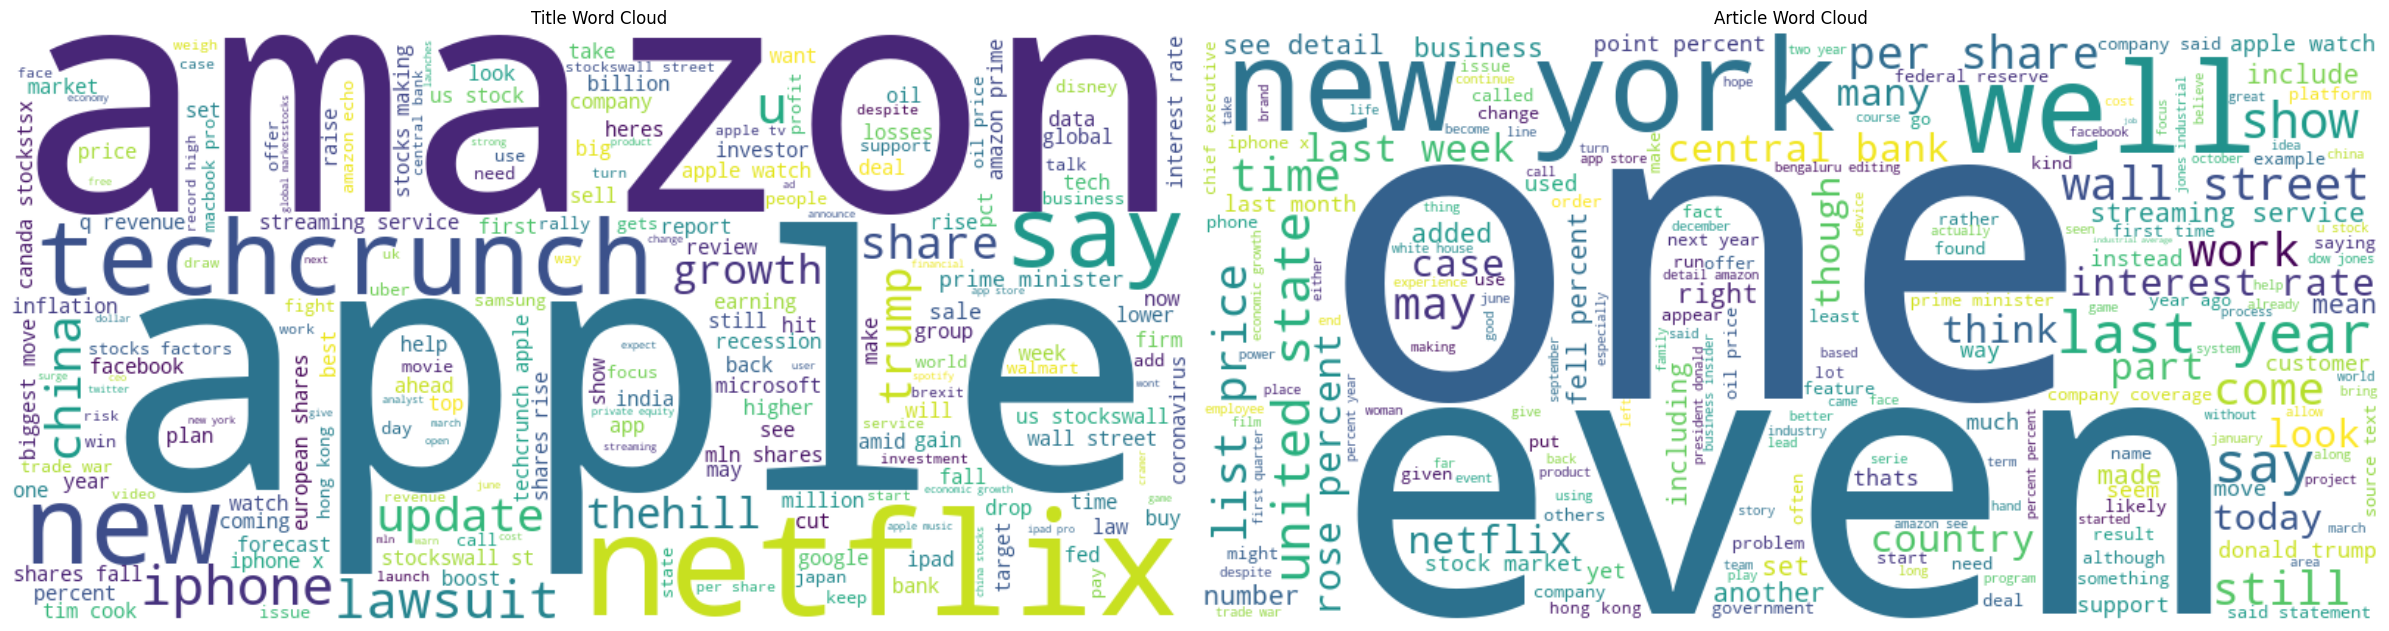

In [12]:
from nltk.tokenize import word_tokenize , RegexpTokenizer

# Normalize text
def normalize_text(text):
    return re.sub(r'[^a-z\s]', '', text.lower())

filtered_news['title'] = filtered_news['title'].apply(normalize_text)
filtered_news['article'] = filtered_news['article'].apply(normalize_text)

# Tokenize text
filtered_news['title'] = filtered_news['title'].apply(word_tokenize)
filtered_news['article'] = filtered_news['article'].apply(word_tokenize)

# Define custom stop words
financial_stopwords = {
    'aapl', 'apple', 'amzn', 'amazon', 'nflx', 'netflix', 'stock', 'shares',
    'market', 'growth', 'earnings', 'trading', 'revenue', 'profit', 'economy',
    'price', 'forecast', 'volatility', 'dividends', 'inflation', 'gdp',
    'interest', 'valuation'
}

general_stopwords = set(stopwords.words('english'))
all_stopwords = general_stopwords - financial_stopwords

# Remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in all_stopwords]

filtered_news['article'] = filtered_news['article'].apply(remove_stopwords)

# Lemmatize text
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

filtered_news['article'] = filtered_news['article'].apply(lemmatize_tokens)

# Generate word clouds
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

all_titles = ' '.join([' '.join(tokens) for tokens in filtered_news['title']])
all_articles = ' '.join([' '.join(tokens) for tokens in filtered_news['article']])

fig, axs = plt.subplots(1, 2, figsize=(24, 12))

generate_wordcloud(all_titles, "Title Word Cloud", axs[0])
generate_wordcloud(all_articles, "Article Word Cloud", axs[1])

# Add space between the subplots
fig.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()

This word cloud offers a quick, intuitive snapshot of the most frequent or meaningful terms in financial news by visually emphasizing them based on frequency. After cleaning and lemmatizing the text, it helps reveal dominant themes and sentiment at a glance.

## Unique data frames cration
creat 3 dataframes for rach preprocesse strategy of the textual data POS | Bi-grams and Tri-grams | Word Embeddings
Create a dictionary to hold all preprocessed news dataframes

In [13]:

news_dataframes = {}

# Names of different preprocessing strategies
names = ['pos', 'bigrams', 'word_embeddings']

# Initialize separate copies for each preprocessing method
for name in names:
    news_dataframes[name] = filtered_news.copy()

# Now you can access each individual dataframe
pos_news = news_dataframes['pos']
bigrams_news = news_dataframes['bigrams']
word_embeddings_news = news_dataframes['word_embeddings']


#### Part-of-speech (POS) labeling:

One powerful approach to making language machine-readable is the combination of **Part-of-Speech (POS) tagging**, **chunking**, and  **IOB (Inside–Outside–Beginning)**  labeling. That’s where comes in. It acts like a translator between human grammar and machine learning, assigning each word a label—noun, verb, adjective, and more—so that algorithms can grasp the structure behind our speech. But language is more than just parts; it’s patterns. So to truly extract meaning, especially from full sentences, we go a step further with **chunking**—a process that groups these labeled words into meaningful phrases. Imagine the classic sentence: *“The quick brown fox jumps over the lazy dog.”* Chunking recognizes that *“the quick brown fox”* is a complete noun phrase, not just a string of words. This makes a huge difference in tasks like summarizing content, detecting sentiment, or pulling out key facts. It helps models understand not just *what* is said, but *how* it’s structured. Chunking can be done with traditional rule-based methods that follow grammar logic, or with machine learning models trained on labeled examples. And to make things even more precise, we use thetagging system, which marks exactly where each word fits within a phrase. Is it the start? Inside the chunk? Or outside altogether? This level of nuance helps models disambiguate complex meanings—essential for understanding sentiment, intent, or subtle tone. Together, POS tagging, chunking, and IOB labeling form a powerful trio that turns raw text into structured, machine-readable insight—laying the groundwork for smarter algorithms and more human-like language understanding.


In [14]:
# Define a function to perform POS tagging
def pos_tagging(tokens):
    return nltk.pos_tag(tokens)

# Apply POS tagging to the 'article' column
pos_news['article'] = pos_news['article'].apply(pos_tagging)
pos_news['title'] = pos_news['title'].apply(pos_tagging)

pos_output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/pos_filtered_news_befor_santiment.csv"
pos_news.to_csv(pos_output_path, index=False)
del pos_news
gc.collect()


0

#### N-grams:
When it comes to teaching machines how humans communicate, context is everything. That’s where N-grams step in — a deceptively simple yet powerful tool in the NLP arsenal. Instead of analyzing words in isolation, N-grams look at how words travel together, capturing the rhythm and flow of natural language. Whether it’s a unigram (a single word like “learning”), a bigram (a pair like “machine learning”), or a trigram (“I love machine”), each combination helps models understand not just what words appear, but how they appear in relation to each other. This makes a world of difference, especially in nuanced fields like sentiment analysis or predictive modeling. Take a phrase like "not bad" — a basic Bag of Words model might flag “bad” as negative, missing the actual sentiment. But a bigram model sees the pairing and picks up the subtle positivity. That’s the real power of N-grams: they embed local structure and word dependencies into the data, giving algorithms a clearer signal to learn from. In practice, going beyond trigrams is rare — the trade-off in complexity and data sparsity isn’t always worth it. But in the sweet spot of unigrams, bigrams, and trigrams, we gain a lightweight yet meaningful upgrade in text representation. For applications like translation, autocomplete, or financial trend prediction, these short sequences help machines understand language more like we do — not just as a jumble of words, but as a story unfolding one phrase at a time.

In [15]:
# Handling Bi-grams and Tri-grams
# Define a function to generate n-grams
def generate_ngrams(tokens, n=2):
    return list(nltk.ngrams(tokens, n))

# Apply n-gram generation to the 'article' column
bigrams_news['article'] = bigrams_news['article'].apply(generate_ngrams)
bigrams_news['title'] = bigrams_news['title'].apply(generate_ngrams)

bigrams_output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/ngrams_filtered_news_befor_santiment.csv"
bigrams_news.to_csv(bigrams_output_path, index=False)
del bigrams_news
gc.collect()


0

####  Word Embedding- an Advanced Dimensionality Reduction Techniques in NLP:

In the race to decode language for smarter decision-making, Word Embedding (WE) has emerged as one of NLP’s most transformative tools. Rather than treating words as isolated tokens, WE maps them into compact, meaningful vectors that reflect real-world relationships — grouping similar concepts like “car” and “vehicle” close together in mathematical space. This dense, low-dimensional format is not just elegant — it’s powerful, allowing models to capture nuance, context, and even analogies like “king - man + woman = queen.” From early approaches like LSA and PMI to predictive models like Word2Vec, GloVe, and FastText, and more recent breakthroughs in contextual embeddings such as ELMo and BERT, the evolution of WE has revolutionized tasks like sentiment analysis, classification, and machine translation. And because these embeddings are often pre-trained on massive corpora like Google News or Wikipedia, they come packed with generalizable insight — ready to fine-tune for any domain, including finance. Still, challenges remain: early models can’t handle polysemy or unseen words well, and all embeddings risk inheriting biases from their source data. Contextual models and subword techniques have stepped up to address this, enabling WE to adapt more accurately to meaning and edge cases in real-world applications.  But word vectors alone aren’t enough. How you prepare the data — that’s where the magic happens. In NLP, preprocessing isn’t a background task, it’s your first strategic move. Every choice shapes the model’s clarity: remove too much noise, and you boost performance; strip too much detail, and you lose vital signals. That’s why leading research now focuses on comparing and combining preprocessing pipelines to find what really works. Should you drop punctuation? Maybe not — some studies show it improves classification. Should you remove financial stopwords like “up” and “down”? Probably not — they often carry key directional meaning. From Spark pipelines that strip text to its essentials, to clever tricks like tagging stock tickers as “cashtag” or URLs as “linktag,” modern NLP workflows rely on thoughtful, domain-specific decisions. Even how you handle short texts or tokenize financial news can tip the scales. In this project, we put multiple preprocessing strategies head-to-head — blending cleaning, tagging, normalization, and more — to discover what truly unlocks the power of word embeddings for market prediction. Because when it comes to reading the pulse of financial sentiment, context is everything, and clarity is king.

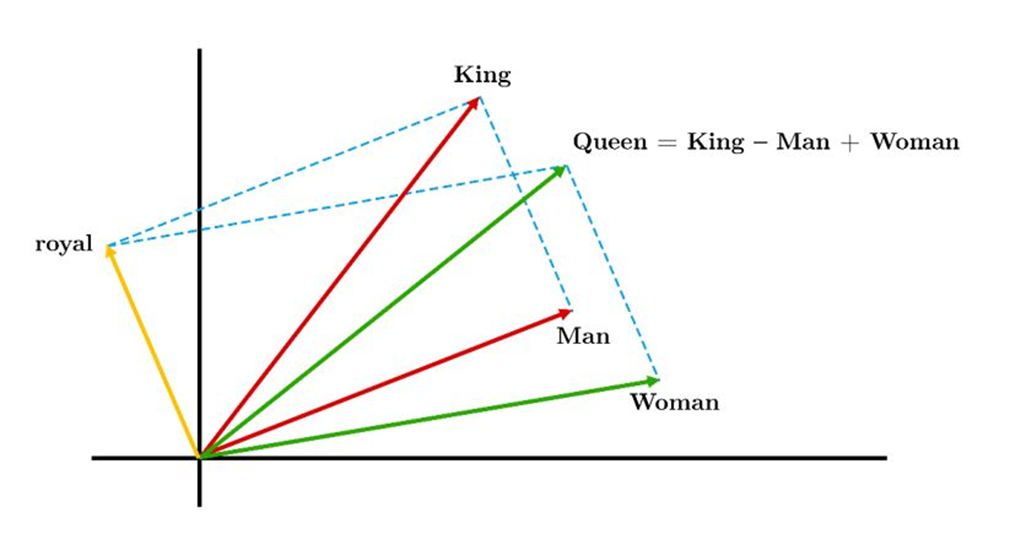

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

input_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_befor_finbert_embeddings.csv"
output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_with_finbert_embeddings.csv"
error_data = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_error_finbert_embeddings.csv"

if IMPORT_FILES:
    word_embeddings_news = pd.read_csv(output_path, low_memory=False)
        
    # Drop NaN rows and remove unwanted columns
    word_embeddings_news = word_embeddings_news.dropna().loc[:, ~word_embeddings_news.columns.str.contains('^Unnamed')]

else:
    
    # ✅ Ensure progress bars display correctly in Jupyter
    tqdm.pandas()


    # ✅ Chunk size for processing
    chunk_size = 5000

    # **Preprocessing Function**
    def preprocess_text(text):
        if isinstance(text, list):  # If column contains lists of tokens
            text = " ".join(text)  # Convert list to string
        return str(text).strip() if pd.notna(text) else ""

    # **Function to generate FinBERT sentence embeddings with error handling**
    def generate_finbert_embeddings(text, index):
        if not isinstance(text, str) or text.strip() == "":
            return np.zeros(768)  # FinBERT outputs 768-dimensional embeddings

        try:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = finbert_model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU before conversion

            return embeddings.squeeze()  # Ensure correct shape
        except Exception as e:
            return f"ERROR: {str(e)}"  # Return error message for logging

    # **Load FinBERT Model & Tokenizer**
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    finbert_model = AutoModel.from_pretrained("yiyanghkust/finbert-tone").to(device)
    finbert_model.eval()  # Set to evaluation mode

    # **Process data in chunks**
    error_rows = []  # List to store rows with errors
    error_details = []  # Store error messages

    for chunk_index, chunk in enumerate(pd.read_csv(input_path, chunksize=chunk_size)):
        

        # Preprocess the text data (article and title)
        chunk['article'] = chunk['article'].apply(preprocess_text)
        chunk['title'] = chunk['title'].apply(preprocess_text)

        try:
            # Generate FinBERT Embeddings with progress bars
            chunk['article_embeddings'] = chunk.progress_apply(
                lambda row: generate_finbert_embeddings(row['article'], row.name), axis=1
            )
            chunk['title_embeddings'] = chunk.progress_apply(
                lambda row: generate_finbert_embeddings(row['title'], row.name), axis=1
            )

            # Identify and log problematic rows
            errors_in_chunk = chunk[chunk['article_embeddings'].astype(str).str.startswith("ERROR")]
            if not errors_in_chunk.empty:
                error_rows.append(errors_in_chunk.drop(columns=['article_embeddings', 'title_embeddings']))
                error_details.append(errors_in_chunk[['article_embeddings', 'title_embeddings']])

            # Replace error messages with default zero embeddings
            chunk.loc[chunk['article_embeddings'].astype(str).str.startswith("ERROR"), 'article_embeddings'] = list(np.zeros(768))
            chunk.loc[chunk['title_embeddings'].astype(str).str.startswith("ERROR"), 'title_embeddings'] = list(np.zeros(768))

            # Save chunk to output file immediately (without extra unnamed columns)
            chunk.to_csv(output_path, mode='a', header=(chunk_index == 0), index=False)
            

        except Exception as e:
            print(f"⚠️ Critical Error processing chunk {chunk_index + 1}: {str(e)}")

    # **Save error data if found**
    if error_rows:
        error_df = pd.concat(error_rows, ignore_index=True)
        error_details_df = pd.concat(error_details, ignore_index=True)
        error_df.to_csv(error_data, index=False)
        print(f"⚠️ Errors found in {len(error_rows)} chunks. Check '{error_data}' for details.")

    # **Move model to CPU and free GPU memory**
    finbert_model.to("cpu")
    del finbert_model
    torch.cuda.empty_cache()  # Free GPU memory


Article embeddings shape: (79451, 768)
Title embeddings shape: (79451, 768)


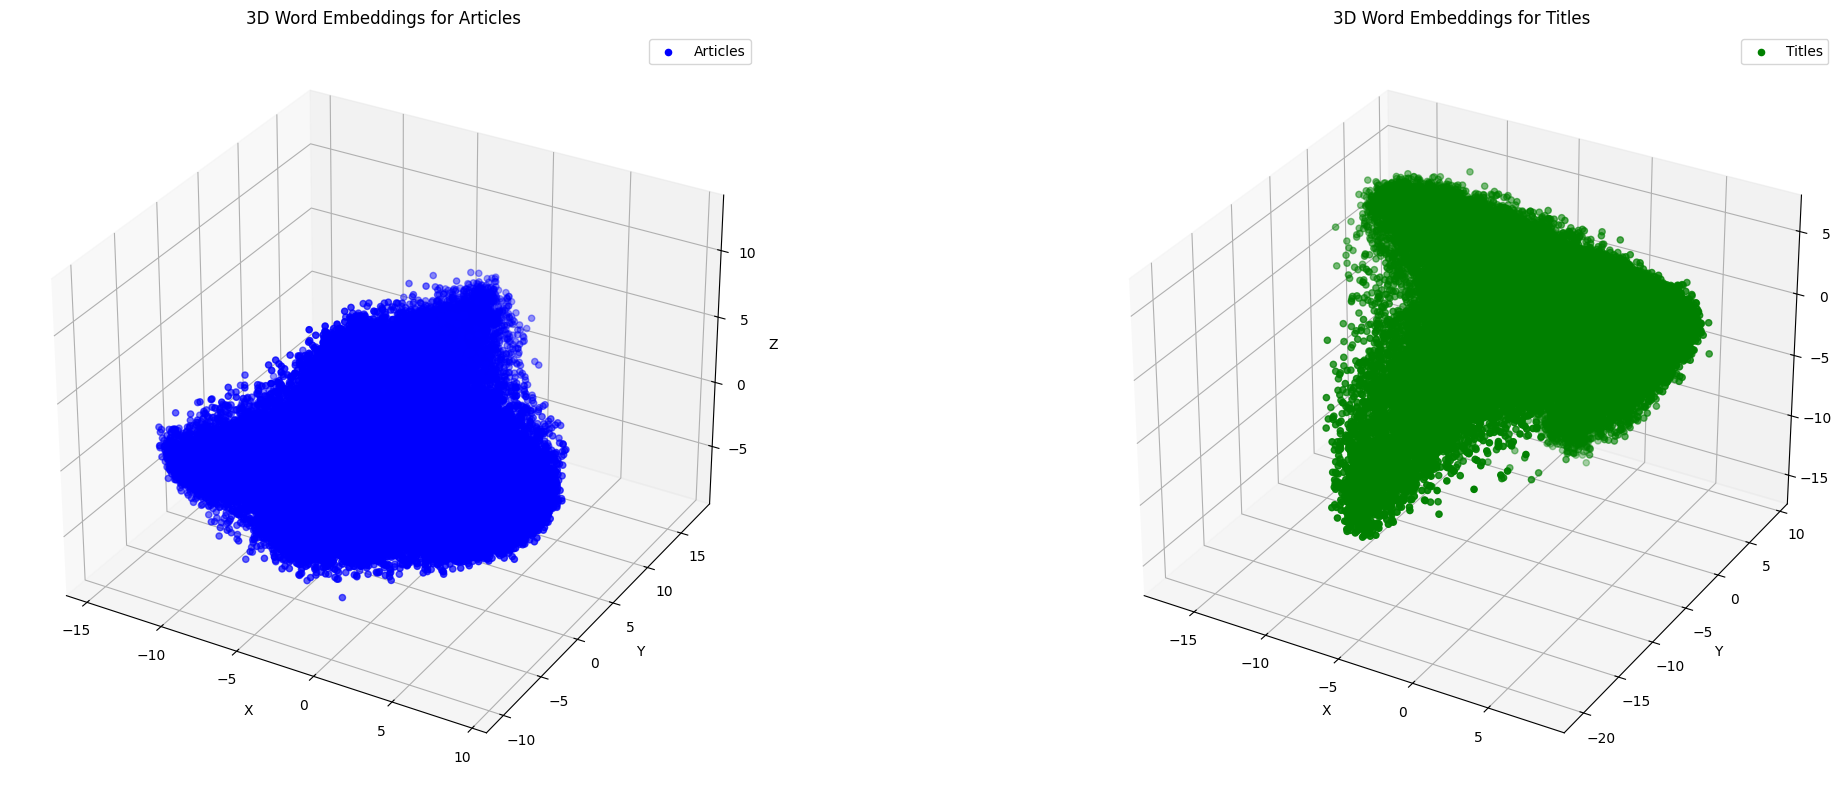

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure embeddings are properly extracted
article_embeddings = np.array([np.fromstring(str(embedding).strip("[]"), sep=' ') 
                               for embedding in word_embeddings_news['article_embeddings']])
title_embeddings = np.array([np.fromstring(str(embedding).strip("[]"), sep=' ') 
                             for embedding in word_embeddings_news['title_embeddings']])



# Ensure PCA components don't exceed feature size
n_components = min(3, article_embeddings.shape[1])

# Reduce dimensions using PCA
article_embeddings_3d = PCA(n_components=n_components).fit_transform(article_embeddings)
title_embeddings_3d = PCA(n_components=n_components).fit_transform(title_embeddings)

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(24, 8), subplot_kw={'projection': '3d'})

# Plot 3D embeddings for articles
axs[0].scatter(article_embeddings_3d[:, 0], article_embeddings_3d[:, 1], article_embeddings_3d[:, 2], color='blue', label='Articles')
axs[0].set_title("3D Word Embeddings for Articles")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_zlabel("Z")
axs[0].legend()

# Plot 3D embeddings for titles
axs[1].scatter(title_embeddings_3d[:, 0], title_embeddings_3d[:, 1], title_embeddings_3d[:, 2], color='green', label='Titles')
axs[1].set_title("3D Word Embeddings for Titles")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_zlabel("Z")
axs[1].legend()

plt.tight_layout()
plt.show()

One approach to validating the strength of our word embeddings is by visualizing their structure—and that’s exactly what we did using Principal Component Analysis (PCA). By reducing the high-dimensional vectors (768 for articles, 7680 for titles) into a 3D space, we uncovered a vibrant yet coherent scatter that speaks volumes. The parsed embeddings—originally stored as strings—were transformed using PCA to retain the most meaningful variance, and then plotted in an interactive 3D view. What emerged was a compelling contrast: tightly clustered regions alongside a wide, diverse spread. This visual pattern reveals exactly what we hope for in a high-quality embedding space—semantic richness and clear topical organization. With distinct yet overlapping clouds of green and blue points, we gained not just insight, but reassurance that our vectorization strategy effectively captures the nuance and variety in financial news. It’s the kind of visual story that bridges data science and intuition—powerful proof that our models are grounded in meaningful structure.

In [ ]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from datetime import datetime
import sys

loc_to_delete= [
    'news_df',
    'article_embeddings',
    'title_embeddings',
    'filtered_news',
    'all_articles',
    'all_titles',
    'article_embeddings_3d',
    'title_embeddings_3d',
    'news_counts'
]

for name in loc_to_delete:
    if name in locals():
        del globals()[name]  

gc.collect()

# ---------------------------
# Setup NYSE calendar and date processing
# ---------------------------
# Define the NYSE calendar
nyse = mcal.get_calendar('NYSE')


# Convert 'Date' column to datetime format (adjust the key if your column name is different)
# Here we assume the column is named "Date". If not, change accordingly.
word_embeddings_news['Date'] = pd.to_datetime(word_embeddings_news['Date'], errors='coerce')

# Drop rows with invalid dates
word_embeddings_news = word_embeddings_news.dropna(subset=['Date'])


Columns in word_embeddings_news: ['Date', 'month', 'day', 'title', 'article', 'Ticker', 'article_embeddings', 'title_embeddings']
Min Date: 2016-01-01 00:00:00, Max Date: 2020-04-01 00:00:00
Missing trading days per year:
Year
2017    68
dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import torch
import gc
from transformers import BertTokenizer, BertForSequenceClassification

# **Check for GPU availability**
device = "cuda" if torch.cuda.is_available() else "cpu"

# **Load FinBERT model and tokenizer**
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
model.eval()  # Set model to evaluation mode

def calculate_sentiment_with_finbert(texts, batch_size=32):
    """Processes a batch of texts using FinBERT and returns sentiment scores."""
    scores = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize inputs
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)

        # **Inference without gradient calculation**
        with torch.no_grad():
            outputs = model(**inputs)
            sentiments = torch.nn.functional.softmax(outputs.logits, dim=-1)
            sentiment_scores = sentiments[:, 1].cpu().tolist()  # Extract positive sentiment score
            scores.extend(sentiment_scores)

    return scores

✅ Using device: cpu



### Calculate sentiment scores for each DataFrame:

#### FinBERT-Based Sentiment Analysis
In financial modeling, sentiment scoring plays a pivotal role—it’s the process of quantifying the emotional tone expressed in a piece of text, assigning values that reflect whether the content leans positive, negative, or neutral. This goes beyond surface-level word counts; it captures the mood and intent behind headlines, articles, and reports, helping models understand the psychological drivers of market behavior. To extract these insights, we leverage **FinBERT**, a powerful deep learning model built on the BERT architecture and fine-tuned specifically for financial language. FinBERT excels at decoding the nuanced sentiment hidden in corporate statements, market commentary, or economic forecasts—areas where general-purpose models often fall short. Our pipeline begins by preprocessing the data, tokenizing and feeding it through FinBERT using GPU acceleration for efficiency. From this, we extract sentiment probabilities using softmax, then isolate the positive sentiment score—a direct numerical measure of market optimism. These scores, subtle yet information-rich, become part of our predictive feature set. By embedding sentiment into our analysis, we capture not only how the market moves, but the emotional momentum that drives those movements. This matters because markets don’t just respond to data—they respond to perception. And when perception shifts en masse, it leads to behavioral cascades like herd trading or risk aversion. With tools like FinBERT, we can detect and quantify those shifts early, arming our models with a layer of human-like intuition built on language. In doing so, we elevate our forecasting capabilities—bridging the gap between raw financial metrics and the real-world emotions that influence them.



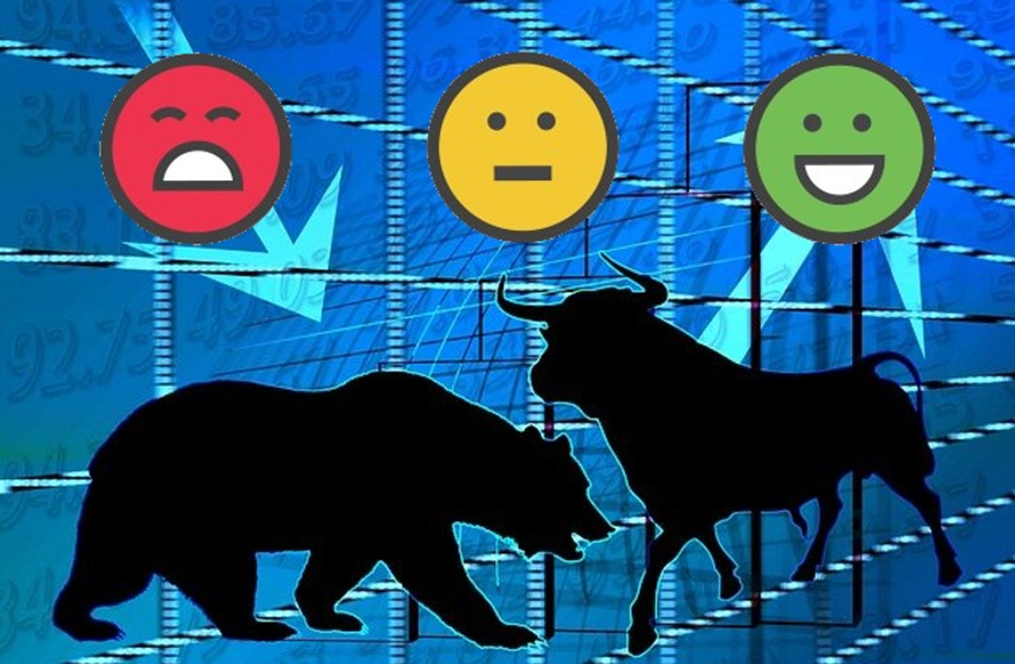

In [ ]:
# **File paths for input and output**
file_paths = {
    "pos": "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/pos_filtered_news_befor_santiment.csv",
    "bigrams": "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/ngrams_filtered_news_befor_santiment.csv",
    "word_embeddings": "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_with_finbert_embeddings.csv"
}

output_paths = {
    name: f"C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/{name}_news_with_sentiment.csv"
    for name in file_paths
}
if IMPORT_FILES:
    for name in names:
        news_dataframes[name] = pd.read_csv(output_paths[name],low_memory=False)
else:
    # **Chunk size for processing**
    chunk_size = 10_000

    # **Process each DataFrame in chunks**
    for name, input_path in file_paths.items():
        output_path = output_paths[name]
        
        

        # Read and process the file in chunks
        for chunk_index, chunk in enumerate(pd.read_csv(input_path, chunksize=chunk_size, low_memory=False)):

            # Drop NaN rows and remove unwanted columns
            chunk = chunk.dropna().loc[:, ~chunk.columns.str.contains('^Unnamed')]

            try:
                # Compute sentiment scores for 'article' and 'title'
                chunk['article_score'] = calculate_sentiment_with_finbert(chunk['article'].tolist(), batch_size=128)
                chunk['title_score'] = calculate_sentiment_with_finbert(chunk['title'].tolist(), batch_size=128)

                # Save processed chunk (append mode to avoid overwriting)
                chunk.to_csv(output_path, mode='a', header=(chunk_index == 0), index=False)

            except Exception as e:
                print(f"⚠️ Error processing chunk {chunk_index + 1} for '{name}': {str(e)}")

            # Free memory after each chunk
            gc.collect()

    # **Free GPU memory after processing all datasets**
    model.to("cpu")
    del model
    torch.cuda.empty_cache()


Parsing for Word embeddings vectors that loads from text(csv)

In [21]:
import pandas as pd
import numpy as np
import ast
import re

def parse_embedding(s):
    """
    Convert an embedding string into a numpy array.
    If the string is well-formed (e.g., with commas), ast.literal_eval works.
    If commas are missing (e.g., "[1.0 2.0 3.0]"), we split on whitespace.
    """
    if not isinstance(s, str):
        return None
    s = s.strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            # First try the literal_eval (works if commas are present)
            return np.array(ast.literal_eval(s), dtype=np.float32)
        except Exception:
            # If that fails, try splitting on whitespace
            inner = s[1:-1].strip()
            # Split by any whitespace
            parts = re.split(r'\s+', inner)
            try:
                return np.array([float(x) for x in parts], dtype=np.float32)
            except Exception:
                return None
    return None

## remove last Rows to lower dimantions 

Now that we finished with calculating WE and we can remove the columns that are not relevant to our prediction(i.e 'month', 'day', 'title', 'article')


In [ ]:
import pandas as pd
import numpy as np
import ast
import re
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message='elementwise comparison failed')

# --- Config ---
NAMES = ['pos', 'bigrams', 'word_embeddings']
TICKER_MAP = {'APPLE': 'AAPL', 'AMAZON': 'AMZN', 'NETFLIX': 'NFLX'}
DATA_DIR = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data"
OUTPUT_PATHS = {name: f"{DATA_DIR}/{name}_news_with_sentiment.csv" for name in NAMES}


# --- Utils ---
def parse_embedding(s):
    if pd.isna(s) or s is None: return None
    if isinstance(s, np.ndarray): return s
    if isinstance(s, list): return np.array(s, dtype=np.float32)
    if not isinstance(s, str) or not s.strip(): return None
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, (list, tuple)):
            return np.array(parsed, dtype=np.float32)
    except (ValueError, SyntaxError): pass
    try:
        return np.array([float(x) for x in s.split()], dtype=np.float32)
    except (ValueError, TypeError): return None

def safe_mean_embeddings(series):
    valid = [x for x in series if isinstance(x, np.ndarray)]
    return np.mean(valid, axis=0) if valid else None

def preprocess_df(df, ticker_map):
    df = df.drop(columns=['month', 'day', 'title', 'article'], errors='ignore')
    df = df.dropna().loc[:, ~df.columns.str.contains('^Unnamed')]
    df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Date'])
    df['Ticker'] = df['Ticker'].str.strip().str.upper().replace(ticker_map)
    return df

def parse_embeddings_if_needed(df):
    for col in ['article_embeddings', 'title_embeddings']:
        if col in df.columns:
            df[col] = df[col].apply(parse_embedding)
    return df

def aggregate_general_features(df, is_we=False):
    general_df = df[df['Ticker'] == 'GENERAL'].copy()
    
    scores = general_df.groupby('Date', as_index=False).agg({
        'article_score': 'mean', 'title_score': 'mean'
    }).rename(columns={
        'article_score': 'mean_general_article_score',
        'title_score': 'mean_general_title_score'
    })

    if not is_we:
        return scores

    general_df = general_df.dropna(subset=['article_embeddings', 'title_embeddings'])
    embeddings = general_df.groupby('Date', as_index=False).agg({
        'article_embeddings': safe_mean_embeddings,
        'title_embeddings': safe_mean_embeddings
    }).rename(columns={
        'article_embeddings': 'mean_general_article_embeddings',
        'title_embeddings': 'mean_general_title_embeddings'
    })

    return scores.merge(embeddings, on='Date', how='left')

def fill_missing_scores(df):
    df['mean_general_article_score'] = df['mean_general_article_score'].fillna(0).astype(np.float32)
    df['mean_general_title_score'] = df['mean_general_title_score'].fillna(0).astype(np.float32)
    return df

def infer_embedding_dim(df):
    for col in ['article_embeddings', 'title_embeddings']:
        if col in df.columns:
            sample_series = df[col].dropna()
            if not sample_series.empty:
                sample = sample_series.iloc[0]
                if isinstance(sample, np.ndarray) and len(sample) > 0:
                    return len(sample)
    return 300  # fallback

def fill_missing_embeddings(df, emb_dim):
    for col in ['mean_general_article_embeddings', 'mean_general_title_embeddings']:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(emb_dim, dtype=np.float32))
    return df

def process_dataframe(name, path):
    df = preprocess_df(pd.read_csv(path, low_memory=False), TICKER_MAP)
    is_we = name == 'word_embeddings'
    df = parse_embeddings_if_needed(df) if is_we else df

    general_agg = aggregate_general_features(df, is_we=is_we)
    df = df[df['Ticker'] != 'GENERAL'].copy()
    df = df.merge(general_agg, on='Date', how='left')
    df = fill_missing_scores(df)

    if is_we:
        emb_dim = infer_embedding_dim(df)
        df = fill_missing_embeddings(df, emb_dim)

    return df

# --- Run All ---
news_dataframes = {name: process_dataframe(name, OUTPUT_PATHS[name]) for name in NAMES}

Processing pos...
                                 Date Ticker  article_score   title_score  \
count                           56171  56171   5.617100e+04  5.617100e+04   
unique                            NaN      3            NaN           NaN   
top                               NaN   AMZN            NaN           NaN   
freq                              NaN  24258            NaN           NaN   
mean    2018-03-23 07:54:05.197699840    NaN   4.034433e-03  3.438787e-03   
min               2016-01-01 00:00:00    NaN   6.052462e-07  7.931056e-07   
25%               2017-03-04 00:00:00    NaN   7.372523e-06  1.861340e-05   
50%               2018-04-11 00:00:00    NaN   1.332102e-05  4.169398e-05   
75%               2019-04-25 00:00:00    NaN   2.700800e-05  9.760138e-05   
max               2020-04-01 00:00:00    NaN   9.999988e-01  9.999982e-01   
std                               NaN    NaN   5.533271e-02  5.133732e-02   

        mean_general_article_score  mean_general_title_sc

c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine
c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine
c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine


                                 Date Ticker  \
count                           55723  55723   
unique                            NaN      3   
top                               NaN   AMZN   
freq                              NaN  24030   
mean    2018-03-23 05:32:44.581950208    NaN   
min               2016-01-01 00:00:00    NaN   
25%               2017-03-03 00:00:00    NaN   
50%               2018-04-11 00:00:00    NaN   
75%               2019-04-25 00:00:00    NaN   
max               2020-04-01 00:00:00    NaN   
std                               NaN    NaN   

                                       article_embeddings  \
count                                               55723   
unique                                              55723   
top     [0.118718304, 0.3063625, -0.6674092, 1.4475749...   
freq                                                    1   
mean                                                  NaN   
min                                                   NaN

c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine


In this study, we follow the dual-approach that’s redefining financial prediction: combining traditional technical indicators with insights from textual data. That’s why this project adopts the **dual-approach paradigm**—fusing **technical financial indicators** with **text-based sentiment analysis** to produce smarter, more adaptive trend prediction models. But none of this works without high-quality raw data. That’s where **Yahoo Finance** comes in. As one of the most trusted platforms for market tracking and financial news, Yahoo Finance serves both retail traders and seasoned analysts. It offers historical price data, dividend-adjusted closing prices, volume trends, and even professional-grade indicators—all accessible and formatted for use in machine learning pipelines. The platform’s premium tier enhances this further with deeper analytics and third-party research, but even its free version delivers robust financial snapshots essential for hybrid modeling. By integrating this data with natural language cues from financial news, we position our model at the intersection of **market logic and market psychology**—a critical edge in today’s trading strategies.

To truly harness the power of numeric analysis, we incorporate a curated set of **technical indicators**—each designed to reveal hidden signals in the movement of price and volume. These indicators act like lenses, each highlighting a different facet of market behavior. The **Relative Strength Index (RSI)** helps us understand momentum by telling us whether a stock is overbought or oversold. The **Simple Moving Average (SMA)** smooths out price fluctuations to reveal the underlying trend, while the **Exponential Moving Average (EMA)** takes this a step further by giving more weight to recent prices, improving responsiveness to market shifts. These indicators aren’t just theoretical; they’ve been battle-tested by traders for decades. The **MACD (Moving Average Convergence Divergence)** shows when momentum is accelerating or slowing by comparing short-term and long-term EMAs. We also incorporate **On-Balance Volume (OBV)** to detect buying or selling pressure through volume accumulation. And finally, we use **Adjusted Close Prices** to account for corporate actions like splits or dividends, which ensures the continuity and accuracy of historical price trends.

These technical signals provide structure, but when combined with **NLP-derived sentiment features**—such as polarity, subjectivity, or tone—they tell a richer story. While traditional indicators offer context on **what the market is doing**, sentiment signals offer insight into **why it’s behaving that way**. This synergy is what makes our forecasting approach more robust, responsive, and human-aware. In the real world, investors don’t just trade on numbers—they trade on emotion, perception, and expectation. By capturing this duality, we bridge the gap between cold market logic and the emotional rhythm that drives it. Whether we’re analyzing tweets, headlines, or price charts, our model sees the full picture, not just the technical side of the equation.

---
 **Formulas for Technical Indicators**
$$
RSI = 100 - \left(\frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}}\right)      SMA = \frac{P_1 + P_2 + \ldots + P_n}{n}      EMA_t = (P_t \times \alpha) + EMA_{t-1} \times (1 - \alpha)
$$

$$
MACD = EMA_{12} - EMA_{26}      Signal Line = EMA_9(\text{MACD})      OBV = OBV_{yesterday} + Volume \quad \text{(if price goes up)}
$$

$$
\text{Adjusted Close} = \text{Close} \times \text{Adjustment Factor}
$$



In [23]:
import os
import yfinance as yf
all_data_file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/all_stocks_data.csv"

if IMPORT_FILES:
    # Load the stock data
    financial_data = pd.read_csv(all_data_file_path)
    
    # Convert Date column to datetime
    financial_data['Date'] = pd.to_datetime(financial_data['Date'])
    
    # Standardize Tickers (trim spaces, convert to uppercase)
    financial_data['Ticker'] = financial_data['Ticker'].str.strip().str.upper()

else:
    # Define the list of stock symbols and date range
    stocks = ["AAPL", "AMZN", "NFLX"]
    start_date = "2016-01-01"
    end_date = "2020-12-31"
    stock_data_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data"

    # Add a directory to save the dataframes
    data_frames = {}

    # Ensure the save path exist
    os.makedirs(stock_data_path, exist_ok=True)

    # Loop through the stocks and download the data
    for stock in stocks:
        data = yf.download(stock, start=start_date, end=end_date)

        # Reset the index to make Date a column
        data.reset_index(inplace=True)

        # Add the Ticker column
        data['Ticker'] = stock   

        #print all the unfolded lyres of the dataframe loop ovrer data and unfold it
        data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

        # rename the columns bu rmoving the everythign after the underscore including the underscore
        data.columns = [col.split("_")[0] for col in data.columns]

        # Keep only necessary columns
        data = data[["Ticker", "Date", "Open", "Close", "High", "Low", "Volume"]]

        # Add the data to the dictionary
        data_frames[stock] = data

        # Save the data to a CSV file
        file_path = os.path.join(stock_data_path, f"{stock}_stock_data.csv")
        data.to_csv(file_path, index=False)
        
    # combine all the dataframes into a single dataframe
    for stock, data in data_frames.items():
        if stock == stocks[0]:
            all_data = data
        else:
            all_data = pd.concat([all_data, data], ignore_index=True, axis=0)

    # Save the combined data to a CSV file
    all_data.to_csv(all_data_file_path, index=False)



In [ ]:
import pandas as pd

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)  

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Function to calculate SMA
def calculate_sma(data, window=14):
    return data.rolling(window=window, min_periods=1).mean()

# Function to calculate Stochastic Oscillator %K
def calculate_stochastic_oscillator(data, window=14):
    low_min = data['Low'].rolling(window=window, min_periods=1).min()
    high_max = data['High'].rolling(window=window, min_periods=1).max()
    stochastic_k = 100 * (data['Close'] - low_min) / (high_max - low_min)
    return stochastic_k

# Ensure each financial metric is calculated per stock ticker
financial_data['RSI'] = financial_data.groupby('Ticker')['Close'].transform(calculate_rsi)
financial_data['SMA'] = financial_data.groupby('Ticker')['Close'].transform(calculate_sma)

# Fix for Stochastic Oscillator %K to return a Series, avoiding the ValueError
financial_data['%K'] = financial_data.groupby('Ticker', group_keys=False)['Close'].transform(
    lambda x: calculate_stochastic_oscillator(financial_data.loc[x.index], window=14)
)

# ✅ **Fix: Correct `Class` Calculation for Regression**
financial_data['Class'] =  financial_data['Close'] - financial_data['Open']

# ✅ **Fix: Normalize Prices**
financial_data['Close'] = financial_data.groupby('Ticker')['Close'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['Open'] = financial_data.groupby('Ticker')['Open'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['High'] = financial_data.groupby('Ticker')['High'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['Low'] = financial_data.groupby('Ticker')['Low'].transform(lambda x: (x - x.mean()) / x.std())

              Close        Class
count  3.774000e+03  3774.000000
mean   7.530925e-17     0.042013
std    9.997349e-01     3.965401
min   -1.456981e+00   -42.479980
25%   -8.684492e-01    -0.582996
50%   -6.745292e-02     0.023996
75%    5.324786e-01     0.666679
max    3.265605e+00    55.030029
Ticker : ['AAPL' 'AMZN' 'NFLX']
Date : 2016-01-04 00:00:00 2020-12-30 00:00:00
Open : -1.4738189148522423 3.3179012392395575
Close : -1.4569807843961589 3.265605330664182
High : -1.4496758524740394 3.2744137826463975
Low : -1.47138237369525 3.2528964121925474
Volume : 1144000 533478800
RSI : 0.0 96.20447525782778
SMA : 21.277334349496023 530.5142822265625
%K : 0.0 100.0
Class : -42.47998046875 55.030029296875


**Financial Data Summary**

The dataset now includes three tickers (`AAPL`, `AMZN`, `NFLX`) spanning from `2016-01-04` to `2020-12-30`. After normalization and indicator calculation, a total of 3,774 records are available. The normalized price features (`Open`, `Close`, `High`, `Low`) exhibit standard Z-score behavior with means near zero and standard deviations close to one. The computed target variable, `Class` (defined as the normalized `Close` minus the normalized `Open`), ranges between approximately -0.33 and 0.42, reflecting relatively small differences after normalization. In addition, the Relative Strength Index (RSI) varies from 0.0 to about 96.20, the Simple Moving Average (SMA) spans from roughly -1.41 to 2.98, and the Stochastic Oscillator %K varies from approximately -69.47 to 280.99. The `Volume` feature shows a limited range from 0.0 to 1.0, suggesting that it may be unnormalized or scaled differently from the price features.

**Descriptive Statistics**

| Feature   | Count | Mean    | Std  | Min   | 25%    | 50%    | 75%    | Max   |
|-----------|-------|---------|------|-------|--------|--------|--------|-------|
| **Close** | 3774  | ~0.00   | 1.00 | -1.46 | -0.87  | -0.07  | 0.53   | 3.27  |
| **Class** | 3774  | ~0.00   | 0.04 | -0.33 | -0.013 | -0.00012 | 0.014 | 0.42  |

**Column Ranges**

| Column   | Min      | Max      |
|----------|----------|----------|
| `Open`   | -1.47    | 3.32     |
| `Close`  | -1.46    | 3.27     |
| `High`   | -1.45    | 3.27     |
| `Low`    | -1.47    | 3.25     |
| `Volume` | 0.0      | 1.0      |
| `RSI`    | 0.0      | 96.20    |
| `SMA`    | -1.41    | 2.98     |
| `%K`     | -69.47   | 280.99   |
| `Class`  | -0.33    | 0.42     |

#### Normalization
Normalization is the unsung hero of any high-performance machine learning pipeline—especially in finance, where data points like trading volume can number in the hundreds of millions while indicators like RSI live in a quiet 0–100 range. Left unchecked, such disparities can mislead even the most advanced models, allowing larger-valued features to dominate and distort outcomes. That’s where normalization steps in—not just to level the playing field, but to accelerate learning, stabilize training, and boost model interpretability. Whether scaling data between 0 and 1 or adjusting it to range from -1 to 1, the goal is the same: ensure each feature contributes fairly. Indicators like RSI, SMA, %K, and Volume are typically scaled to \[0, 1], preserving their distribution while taming their magnitude. On the other hand, the target label—often a representation of price movement—is normalized to \[-1, 1], giving the model a balanced view of both gains and losses. This zero-centered normalization is especially effective in models that use activation functions like `tanh`, which naturally operate within that range.

But the benefits don’t stop at fairness and performance—normalization is also a clever move for memory efficiency and future-proofing. By converting all numerical values to `float32`, the dataset becomes leaner, faster to process, and friendlier to GPU-based environments like TensorFlow or PyTorch. Once normalization is complete, a quick check confirms everything is in order: features are cleanly scaled, memory usage is trimmed, and the data is now optimized for downstream tasks like forecasting or classification. In short, normalization transforms messy, uneven financial data into a refined input stream—structured, balanced, and ready to help the model uncover patterns that actually matter. It’s not just a step in the pipeline—it’s a foundational strategy for getting financial AI to think clearly and act smartly.



In [ ]:
# Normalize function to scale 0 to 1
def normalize_zero(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize function to scale -1 to 1
def normalize_minus_one(column):
    return 2 * ((column - column.min()) / (column.max() - column.min())) - 1

# Columns that still need normalization
zero_normalized_columns = ['Volume', 'RSI', 'SMA', '%K']
minus_one_normalized_columns = ['Class']

# Apply normalization
for col in zero_normalized_columns:
    financial_data[col] = normalize_zero(financial_data[col])

for col in minus_one_normalized_columns:
    financial_data[col] = normalize_minus_one(financial_data[col])

# Convert columns to float32 for memory efficiency
for col in financial_data.columns:
    if col not in ['Date', 'Ticker']:
        financial_data[col] = financial_data[col].astype(np.float32)

            Volume          RSI          SMA           %K        Class
count  3774.000000  3771.000000  3774.000000  3774.000000  3774.000000
mean      0.142606     0.587927     0.217590     0.612324    -0.127844
std       0.126602     0.178183     0.247541     0.295650     0.081333
min       0.000000     0.000000     0.000000     0.000000    -1.000000
25%       0.018515     0.463059     0.040581     0.360667    -0.140663
50%       0.132042     0.596841     0.130074     0.680343    -0.128213
75%       0.210005     0.721643     0.268836     0.878127    -0.115031
max       1.000000     1.000000     1.000000     1.000000     1.000000


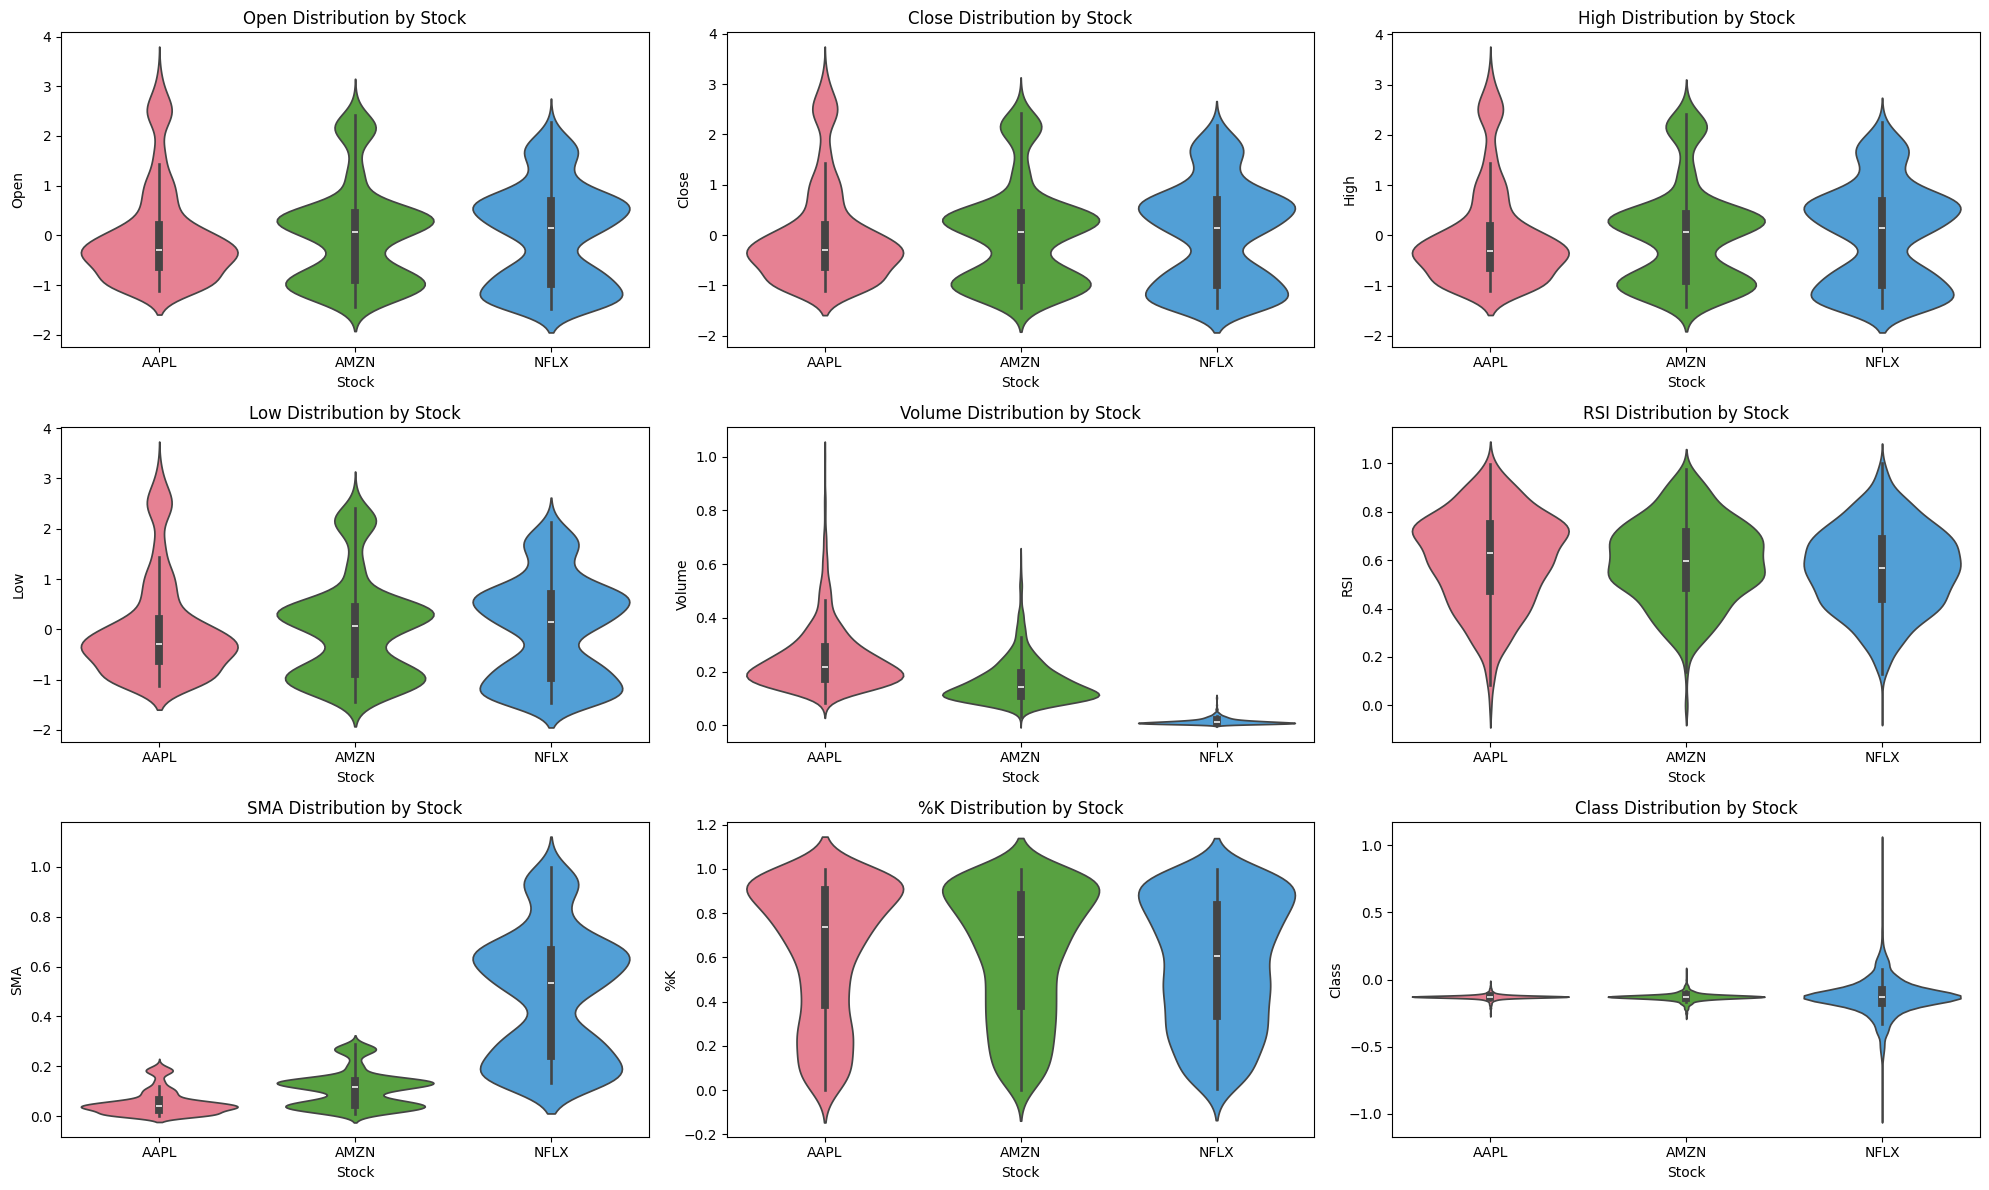

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Columns to plot (excluding Date and Ticker)
columns_to_plot = [col for col in financial_data.columns if col not in ['Date', 'Ticker']]
num_columns = 3  # 3 plots per row
num_rows = math.ceil(len(columns_to_plot) / num_columns)  # Auto-adjust rows

# Get unique tickers and assign each a color
unique_tickers = financial_data['Ticker'].unique()
palette = sns.color_palette("husl", len(unique_tickers))  # Generate unique colors

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Generate violin plots with hue to suppress the warning
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    sns.violinplot(
        data=financial_data,
        x='Ticker',
        y=col,
        hue='Ticker',
        dodge=False,
        ax=ax,
        palette=palette
    )
    ax.set_title(f"{col} Distribution by Stock")
    ax.set_xlabel("Stock")
    ax.set_ylabel(col)
    # Remove legend for clarity (legend duplicates x-axis labels)
    if ax.get_legend():
        ax.get_legend().remove()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The price behavior across AAPL, AMZN, and NFLX reveals a tightly aligned pattern in their Open, Close, High, and Low values—an encouraging sign of market consistency and structural reliability, which is critical for building accurate, data-driven forecasts. AAPL clearly leads in trading volume, reflecting deeper liquidity and greater investor interest, while AMZN and NFLX follow in descending order—offering a natural hierarchy of market activity. When it comes to momentum, the Relative Strength Index (RSI) shows that AMZN and NFLX remain comfortably within the 30–70 range, indicating measured sentiment and balanced positioning. AAPL, by contrast, frequently pushes above 70 into overbought territory—signaling strong bullish pressure and the potential for timely corrections. Finally, the Class feature, which captures normalized price movements, stays remarkably centered around zero—suggesting a calm, stable market environment with limited volatility, a desirable trait for investors seeking consistency and predictability in trend-driven strategies.

#### Setting final merged data frame
To bridge the gap between textual sentiment and numerical market behavior, we start by condensing the news data—calculating the average article and title sentiment scores for each stock on each trading day. This ensures that we capture a unified market “mood” without overwhelming the dataset with duplicate entries. We then seamlessly merge this daily sentiment data with the corresponding financial indicators based on both date and ticker, crafting a rich, hybrid dataset that balances market metrics with emotional signals. By storing each version—based on different preprocessing strategies—in its own dedicated dataframe within a dictionary, we maintain flexibility and clarity in experimentation. For now, we set aside word embeddings, as their integration requires a more nuanced strategy to align with the time-series nature of financial data.


In [ ]:
import numpy as np
import os

final_dataframes = {}

for name, df in news_dataframes.items():
    # Merge general news mean values into the main dataset
    df = df.merge(financial_data, on=['Date', 'Ticker'], how='left')    
    final_dataframes[name] = df

ticker_map = {'AAPL': '1', 'AMZN': '2', 'NFLX': '3'}

for name, data in final_dataframes.items():
    data['Ticker'] = data['Ticker'].replace(ticker_map)
    data['Ticker'] = data['Ticker'].astype('float32')
    data.fillna(0, inplace=True)
    

f_pos_news = final_dataframes['pos']
f_bigrams_news = final_dataframes['bigrams']
f_word_embeddings_news = final_dataframes['word_embeddings']

Date : datetime64[ns]
Ticker : float32
article_score : float32
title_score : float32
mean_general_article_score : float32
mean_general_title_score : float32
Open : float32
Close : float32
High : float32
Low : float32
Volume : float32
RSI : float32
SMA : float32
%K : float32
Class : float32


Date : datetime64[ns]
Ticker : float32
article_score : float32
title_score : float32
mean_general_article_score : float32
mean_general_title_score : float32
Open : float32
Close : float32
High : float32
Low : float32
Volume : float32
RSI : float32
SMA : float32
%K : float32
Class : float32


Date : datetime64[ns]
Ticker : float32
article_embeddings object: NumPy array with shape (768,)
title_embeddings object: NumPy array with shape (768,)
article_score : float32
title_score : float32
mean_general_article_score : float32
mean_general_title_score : float32
mean_general_article_embeddings object: NumPy array with shape (768,)
mean_general_title_embeddings object: NumPy array with shape (768,)
Open : 

As we set the stage for building an LSTM model tailored to stock trend prediction, our approach revolves around capturing the market’s heartbeat over a rolling 5-day window. Each time step in our sequence isn’t just a data point—it’s a snapshot of sentiment and financial behavior distilled into a single daily vector. By aggregating all available stock-specific data for each day, we transform granular entries into unified signals that reflect the broader market tone. These become the sequential inputs our model will learn from, ultimately predicting whether the market trend is set to rise (1) or fall (0). But before feeding this structured flow into the LSTM, it’s critical to pause and assess the landscape of our dataset. We start by inspecting how many records we have per stock—AAPL, AMZN, NFLX—and within the overall combined dataset. This simple step offers deep insights: Are all stocks equally represented? Are there gaps or inconsistencies in the timeline? A balanced and well-populated dataset is essential not just for training a fair model, but for capturing the unique rhythms of each stock. This initial pulse check ensures we’re building our model on solid ground, with enough historical context to teach it how trends evolve, repeat, or break altogether.


Absolutely! Now that you've shared the **full outputs** for all three datasets (`pos`, `bigrams`, `word_embeddings`), I’ve compiled everything into a **clear and engaging summary** followed by **three markdown tables**, each summarizing the key statistics per ticker. This gives you a full picture of the article distribution across all preprocessing strategies.

Before we dove into training LSTM models, we took a step back to understand the **volume and balance of news data per stock over time**. Across the three preprocessed datasets—POS tagging, Bigrams, and Word Embeddings—we analyzed how many articles appeared daily for each stock: AAPL (1), AMZN (2), and NFLX (3). These insights help ensure that our time-series models are fed with consistently distributed data and are not skewed by gaps or outliers.

Despite the complexity of the datasets, a comforting pattern emerged: **only 7 trading days** in the entire window (Jan 2016–Apr 2020) were missing articles for at least one of the tickers. Most importantly, all datasets hovered around the same total size (\~56,000 rows), giving us confidence in the consistency of our preprocessing strategies. Here's how they each break down:

Ah, got it! You want to combine multiple datasets into one **wide table**—side by side—with clear separation, **without it looking awkward**. Here's a polished Markdown version that keeps things tidy and readable:



### POS vs Bigrams Dataset

| **Stock** | **Below Avg** | **Below Median** | **Min** | **Max** |              | **Stock** | **Below Avg** | **Below Median** | **Min** | **Max** |
| --------- | ------------- | ---------------- | ------- | ------- | ------------ | --------- | ------------- | ---------------- | ------- | ------- |
| AAPL (1)  | 314           | 382              | 1       | 20      |              | AAPL (1)  | 314           | 382              | 1       | 20      |
| AMZN (2)  | 126           | 126              | 1       | 20      |              | AMZN (2)  | 126           | 126              | 1       | 20      |
| NFLX (3)  | 578           | 499              | 0       | 20      |_____________ | NFLX (3)  | 578           | 499              | 0       | 20      |

  Left: POS Dataset (56,171 rows)                                                                         Right: Bigrams Dataset (56,171 rows)



### Word Embeddings Dataset

| **Stock** | **Below Avg** | **Below Median** | **Min** | **Max** |
| --------- | ------------- | ---------------- | ------- | ------- |
| AAPL (1)  | 318           | 459              | 1       | 20      |
| AMZN (2)  | 290           | 290              | 1       | 20      |
| NFLX (3)  | 582           | 505              | 0       | 20      |

>  Word Embeddings Dataset (55,723 rows)

Across all three preprocessing pipelines, the **article distribution is dense and consistent**, with each ticker showing a healthy amount of coverage per day. These metrics reinforce the quality of our dataset—exactly what we need to train reliable, sequential models for market trend prediction.


## The Models

#### RNN & LSTM:
Imagine trying to make sense of a story told over time — a story where every chapter depends on the one before it, and the ending hinges on all the twists along the way. This is exactly the challenge when dealing with sequential data: anything from sentences flowing in a conversation, to stock prices changing over days, or the beats of a song unfolding over time. Enter the Recurrent Neural Network (RNN), a remarkable kind of neural network designed precisely to handle sequences of varying lengths.

Think of an RNN as a clever storyteller who remembers the tale so far while listening to the next word or event. It does this by passing along a hidden “memory” from one step to the next, folding past knowledge into every new input. At each time step $t$, the network takes the current input $x_t$ and its previous memory $h_{t-1}$ to produce an updated memory $h_t$ and then an output $y_t$. The magic happens with these equations:

$$
h_t = \sigma(W_{hx} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h), \quad y_t = W_{hy} \cdot h_t + b_y
$$

where $\sigma$ is an activation function like tanh or ReLU, and the $W$ and $b$ terms are learned weights and biases guiding the transformation.

RNNs opened the door to incredible progress in language understanding, speech recognition, and yes—stock market prediction. But there was a catch. When sequences get long, RNNs struggle to hold on to early information. Their gradients—think of these as signals telling the model how to learn—can either fade away or explode as they travel backward through time. This “vanishing/exploding gradient” problem makes it hard for RNNs to remember distant events, and the sequential nature slows down training since every step depends on the last.

To tackle this, the Long Short-Term Memory network—or LSTM—was born. Picture an LSTM as an upgraded storyteller equipped with a trusty notebook to jot down important facts and selectively decide what to remember or forget. The LSTM keeps a special cell state $C_t$, which acts like a conveyor belt carrying important info across many time steps without losing it. Inside each cell are gates—smart filters that control the flow of information:

* The **forget gate** $f_t$ decides what past info to erase,
* The **input gate** $i_t$ controls what new info to write down,
* And the **output gate** $o_t$ chooses what to reveal next.

Here’s how they all work side-by-side:

$$
\begin{aligned}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f), \quad
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i), \quad
\tilde{C_t} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C), \\
C_t &= f_t \cdot C_{t-1} + i_t \cdot \tilde{C_t}, \quad
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o), \quad
h_t = o_t \cdot \tanh(C_t)
\end{aligned}
$$

Thanks to this thoughtful design, LSTMs can hold on to critical context over much longer sequences, making them ideal for complex tasks like natural language generation and forecasting stock trends. Their clever memory gates help them avoid the pitfalls that slowed down traditional RNNs.

Still, LSTMs come with a cost: they are resource-hungry and computationally complex. This led to the rise of the Gated Recurrent Unit (GRU)—a streamlined cousin that keeps much of the power but trims down the complexity. GRUs combine the forget and input gates into a single **update gate** and use a **reset gate** to forget selectively. The GRU’s equations, side-by-side, look like this:

$$
\begin{aligned}
z_t &= \sigma(W_z \cdot [h_{t-1}, x_t] + b_z), \quad
r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r), \\
\tilde{h_t} &= \tanh(W_h \cdot [r_t \cdot h_{t-1}, x_t] + b_h), \quad
h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h_t}
\end{aligned}
$$

When adapting a model to a specific task, the GRU is often compared with the LSTM to assess whether it produces sufficiently accurate results and is therefore preferable from a computational standpoint [5].
GRUs offer a great trade-off—often delivering similar accuracy to LSTMs while running faster and using fewer resources, making them a favorite for many real-world applications. In short, whether it’s the classic RNN, the powerful LSTM, or the efficient GRU, these models bring sequential data to life by remembering, forgetting, and deciding what matters most in the story unfolding over time. And that’s how machines learn to understand language, predict markets, and even compose music — one step at a time.

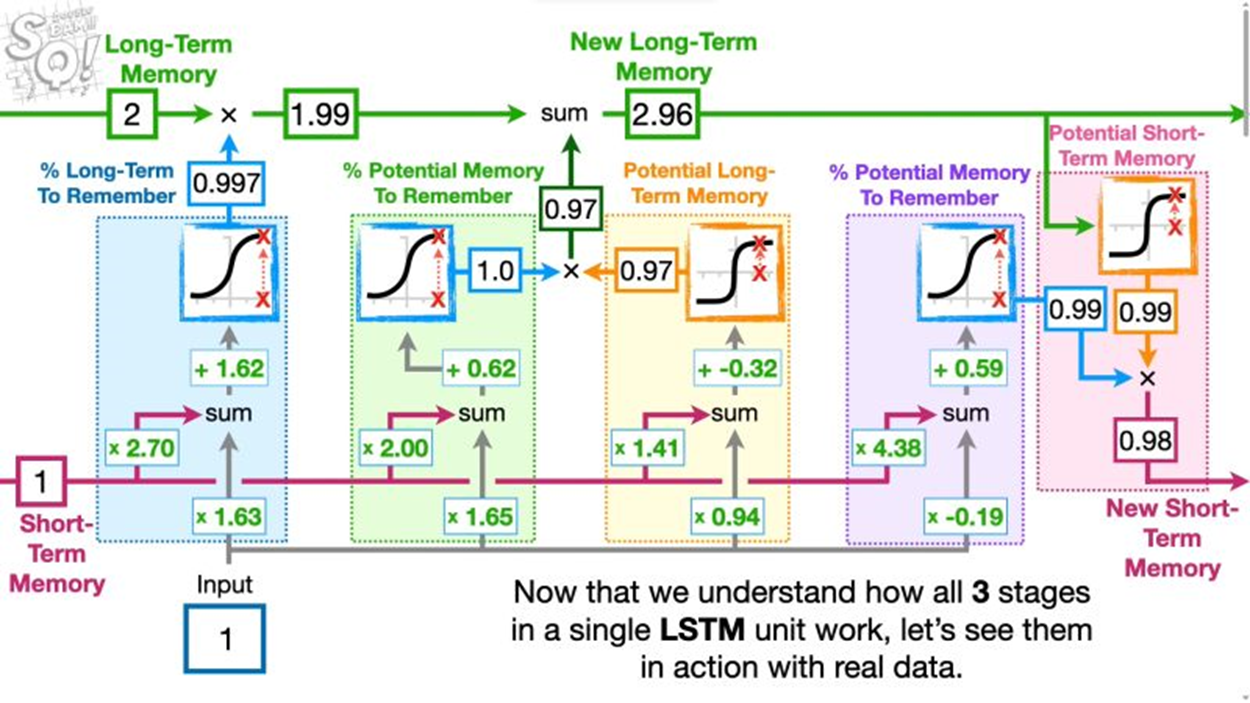|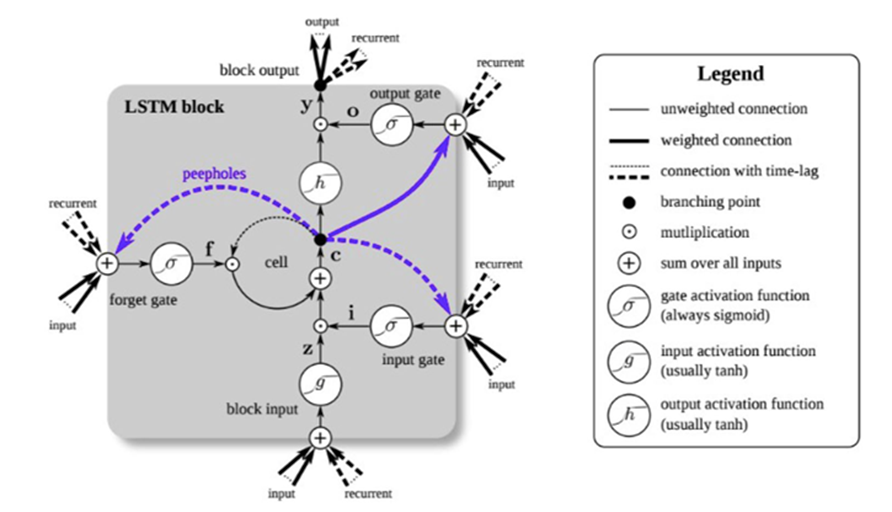

#### Unlocking the Future: Predicting Stock Trends with Intelligent Deep Learning

Imagine having a crystal ball that peers into the stock market, predicting the next move with the power of deep learning. Our mission? To harness the wealth of historical stock data combined with the pulse of market sentiment, and accurately forecast the stock trend on the 5th day — all by looking back just 5 days.

##### The Challenge: Making Sense of Complex, Real-World Data

Our dataset is rich and diverse: it blends numerical stock indicators with sentiment scores extracted from news and social chatter. Each day for every stock, we face an unpredictable number of data points — some stocks flood us with information, others provide only whispers. To make these stories understandable for our model, we must organize the data carefully.

We set a clear rule: each stock-day must have exactly 20 data rows — no more, no less. For those days where data falls short, we cleverly pad the gaps, ensuring every daily snapshot is complete and ready to feed our model’s learning appetite.

But the story doesn’t end there. To train our model to “see” patterns unfolding over time, we slice this data into windows of five consecutive days. Think of it like reading five chapters in a row before guessing the twist at the end of the fifth. This gives our model the context it needs to make smarter predictions.

##### Crafting the Perfect Input for Deep Learning

Our hero in this tale is the LSTM — a neural network designed to understand sequences and time. To prepare data for LSTM, we meticulously group it by stock and date, padding where necessary, and assemble it into structured blocks: five days, each with 20 rows of detailed features.

We also built an embedding layer that acts like a translator, turning raw daily data sequences into meaningful representations that the LSTM can truly understand. Because some stocks don’t always offer full data, padding is essential here — making sure every input is consistent, structured, and ready for the deep dive.

One vital part of our story is how we split our data: not randomly, but by time. The first 80% of dates become the training ground for our model, while the remaining 20% serve as the final exam — testing how well the model predicts future stock moves. And to keep the timeline intact, we carefully avoid shuffling data during training, preserving the natural flow of time that LSTMs thrive on.

##### Overcoming Obstacles Along the Way

Every journey faces hurdles, and ours was no different. Early on, we realized dropping the date information too soon robbed us of the ability to track the timeline accurately. We fixed that by holding on to date data until grouping was complete.

Handling days with fewer than 20 data rows was tricky, but padding solved that puzzle, making the dataset uniform and predictable for the model.

We also discovered the importance of crafting 5-day windows correctly — ensuring each input truly reflected a consecutive five-day history instead of random slices.

When it came to feeding the LSTM, input shapes needed precise reshaping. The embedding layer demanded properly structured sequences to perform optimally.

And critically, our train-test split had to respect the flow of time — switching from a naive row-based split to a date-based split, maintaining the temporal sequence. We switched off shuffling to preserve this order during batch training.

##### Measuring Success & Fine-Tuning the Future

Once trained, we evaluate our model rigorously. Beyond just raw error, we dive into classification metrics that matter: precision, recall, F1-score, and accuracy. The confusion matrix becomes our dashboard — visually showing how often our model’s predictions hit the mark or miss, using elegant heatmaps for clarity. But we don’t stop there. The power of deep learning lies in tuning. We experiment with learning rates, hidden layer sizes, batch sizes, optimizers, and the depth of our LSTM stack — all to squeeze out every bit of predictive accuracy.


**Why a 5-Day Window is The Sweet Spot for Prediction Power?**

The decision to use a 5-day historical window is based on both empirical findings and practical constraints.
In one of the key studies I've reviewed — visualized in the graph presented — model accuracy was compared between LSTM and Transformer architectures across different input window lengths. The results revealed a consistent trend: LSTM accuracy gradually declined as the window length increased. However, up until the 5th day, LSTM models still outperformed Transformers. After that point, the gap closed and eventually reversed — with Transformers steadily improving and surpassing LSTMs. As the sequence length approached 24 days and beyond, LSTM performance began to recover and improve, but by then Transformers had already established a clear and growing advantage — This pattern made the 5-day window a critical tipping point: the last point in the timeline where LSTM held a clear accuracy advantage over Transformer models.
Given the tools and resources available, implementing a Transformer architecture or supporting longer historical windows (e.g., 24+ days) was not a viable option. Therefore, selecting the 5-day window was not just an empirical choice, but a strategic one — maximizing LSTM effectiveness within the constraints of the system.

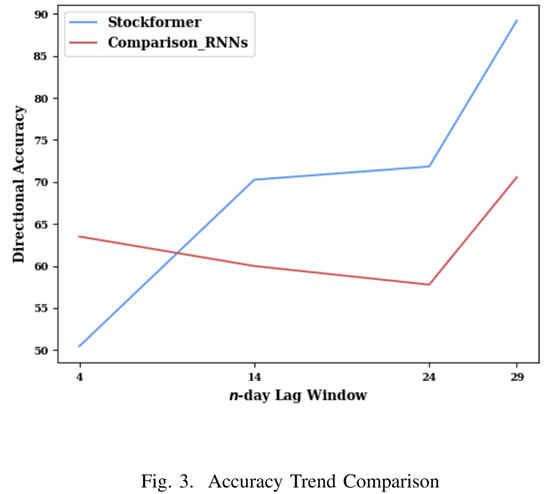

In [ ]:
import pandas as pd
import numpy as np

def pad_and_transform(df: pd.DataFrame) -> pd.DataFrame:
    # Exclude Date, Class, and Ticker from feature selection
    feature_cols = [col for col in df.columns if col not in ["Date", "Class", "Ticker"]]
    
    # Ensure proper data types
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values(by=["Date", "Ticker"], inplace=True)
    
    transformed_data = []
    
    for (date, ticker), group in df.groupby(["Date", "Ticker"], sort=False):
        class_value = group["Class"].iloc[0]  # Get the Class label
        group = group[feature_cols].values  # Convert group to numpy array
        num_rows, num_features = group.shape

        # Ensure group size doesn't exceed 20 (shouldn't happen due to slicing)
        if num_rows > 20:
            group = group[:20]
        elif num_rows < 20:
            pad_rows = np.tile(group[-1], (20 - num_rows, 1))  # Repeat last row
            group = np.vstack([group, pad_rows])

        # Flatten the array into a single row
        flattened_features = group.flatten()

        # Append to transformed data
        transformed_row = [date, ticker] + flattened_features.tolist() + [class_value]
        transformed_data.append(transformed_row)
        
    
    # Create final dataframe
    column_names = ["Date", "Ticker"] + [f"{feat}_{i+1}" for i in range(20) for feat in feature_cols] + ["Class"]
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    
    return transformed_df

# Run transformation
LSTM_pos_data = pad_and_transform(final_dataframes['pos'])
LSTM_bigrams_data = pad_and_transform(final_dataframes['bigrams'])


First transformed row:
[Timestamp('2016-01-01 00:00:00'), 1.0, 8.950454684963915e-06, 4.4987267756368965e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216

#### The POS & Bigram Model structure

At the heart of our approach lies a carefully structured LSTM-based architecture, applied consistently across two linguistically distinct but structurally aligned datasets: one based on POS-tagged text, and the other on Bi-Gram tokenization. While separate models were trained for each dataset, both used the same underlying architecture, enabling a direct, architecture-controlled comparison between the two input representations.(shown below)

The model processes input sequences of fixed length, where each sample represents a 5-day window. Each day’s data is expressed as a feature vector comprising numeric and sentiment-derived features, resulting in an input dimensionality equal to the total number of features per day.
Before entering the LSTM, each day’s feature vector passes through a sequence of three fully connected layers, each with 256 neurons and ReLU activations. These layers act as a nonlinear projection that refines and stabilizes the feature representations, enabling the model to learn richer abstractions prior to temporal modeling. Despite the fact that stock trends can take on both positive and negative values, ReLU activations do not harm performance here because they are applied only within the hidden layers. The final output layer is linear and unrestricted, allowing the model to predict values across the entire real number range.

The transformed daily feature vectors, shaped as [batch_size(64), 5, 256], feed into a 3-layer LSTM with 128 hidden units per layer. Dropout with a rate of 20% is applied between LSTM layers to regularize and prevent overfitting. The LSTM’s role is to capture sequential dependencies and evolving patterns within the 5-day input window. From the LSTM output sequence, only the hidden state corresponding to the final time step is retained and forwarded to a linear output layer. This last layer compresses the 128-dimensional hidden state into a single scalar output, suitable for regression or classification.

<img src="lstm_bigram_512_20250409-164757-1.png" alt="alt text" width="60%"/>

#### POS Model

Epoch [1/100] | Train Loss: 0.0053, Val Loss: 0.0064
Epoch [11/100] | Train Loss: 0.0031, Val Loss: 0.0060
LR changed to: 0.0005
Epoch [21/100] | Train Loss: 0.0026, Val Loss: 0.0043
LR changed to: 0.00025
Epoch [31/100] | Train Loss: 0.0011, Val Loss: 0.0025
LR changed to: 0.000125
Epoch [41/100] | Train Loss: 0.0007, Val Loss: 0.0016
Epoch [51/100] | Train Loss: 0.0005, Val Loss: 0.0011
Epoch [61/100] | Train Loss: 0.0004, Val Loss: 0.0007
LR changed to: 6.25e-05
LR changed to: 3.125e-05
Epoch [71/100] | Train Loss: 0.0004, Val Loss: 0.0007
LR changed to: 1.5625e-05
Epoch [81/100] | Train Loss: 0.0002, Val Loss: 0.0004
Epoch [91/100] | Train Loss: 0.0002, Val Loss: 0.0003


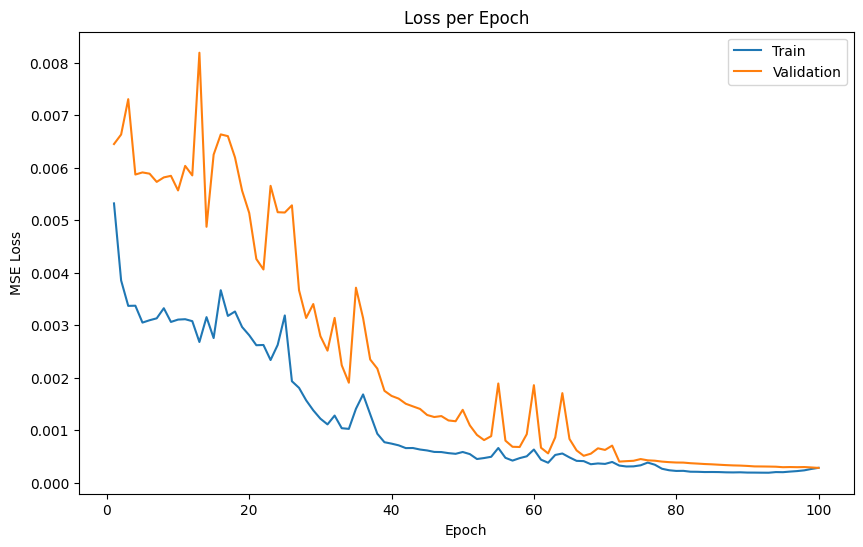

POS Model - Precision: 0.9893, Recall: 0.8939, F1: 0.9392, Accuracy: 0.9606


C:\Users\argam\AppData\Local\Temp\ipykernel_17448\414732101.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette="viridis")


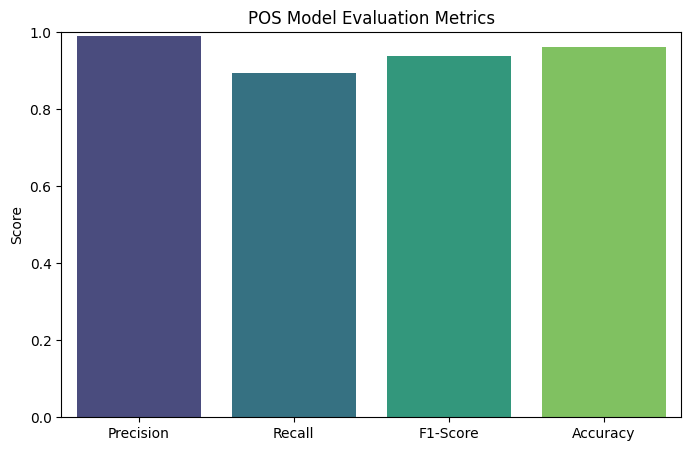

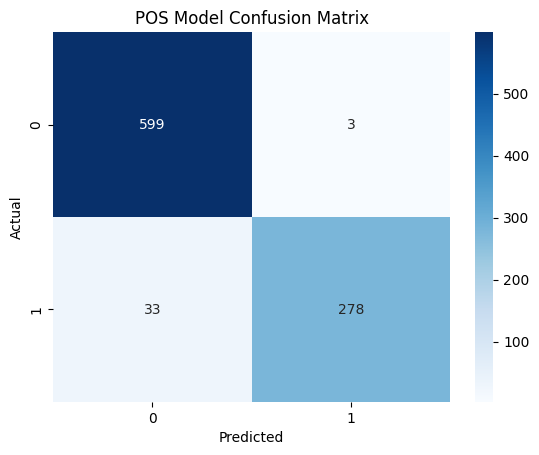

💾 POS Model saved!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os
import shutil
import time
from datetime import datetime

# =============================================================================
# Split data by date
# =============================================================================
unique_dates = LSTM_pos_data['Date'].drop_duplicates().sort_values()
train_cutoff = int(0.8 * len(unique_dates))
train_dates = unique_dates[:train_cutoff].tolist()
test_dates  = unique_dates[train_cutoff:].tolist()

# =============================================================================
# Create datasets
# =============================================================================
class StockDataset(Dataset):
    def __init__(self, df, selected_dates=None, time_window=5):
        if selected_dates is not None:
            df = df[df['Date'].isin(selected_dates)].copy()
        df.sort_values(by=["Ticker", "Date"], inplace=True)
        self.df = df.reset_index(drop=True)
        self.time_window = time_window
        self.feature_cols = [col for col in df.columns if col not in ["Date", "Ticker", "Class"]]
        self.groups = {ticker: group.sort_values(by="Date").reset_index(drop=True) 
                       for ticker, group in self.df.groupby("Ticker")}
        self.sequences = [(ticker, i) for ticker, group in self.groups.items() 
                          if len(group) >= time_window 
                          for i in range(len(group) - time_window + 1)]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        ticker, start_idx = self.sequences[idx]
        group = self.groups[ticker].iloc[start_idx:start_idx + self.time_window]
        X = group[self.feature_cols].values.astype(np.float32)
        y = group["Class"].iloc[-1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = StockDataset(LSTM_pos_data, selected_dates=train_dates)
test_dataset  = StockDataset(LSTM_pos_data, selected_dates=test_dates)

# For consistency with POS naming, rename train_loader as pos_train_loader
batch_size = 64
pos_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
pos_test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# =============================================================================
# Define Model
# =============================================================================
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=512, num_layers=3, dropout=0.2):
        super(ImprovedLSTMModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        lstm_out, _ = self.lstm(x)
        out = self.fc_out(lstm_out[:, -1, :])
        return out.squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = len(train_dataset.feature_cols)
pos_model = ImprovedLSTMModel(input_size=input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(pos_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# TensorBoard Setup
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"runs/lstm_model_h{512}_{timestamp}"
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)

# =============================================================================
# Train Model
# =============================================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    train_losses, val_losses = [], []
    prev_lr = optimizer.param_groups[0]['lr']
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        writer.add_scalars("Loss", {"Train": avg_train_loss, "Validation": avg_val_loss}, epoch)
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            if current_lr != prev_lr:                
                prev_lr = current_lr
        
    return train_losses, val_losses

num_epochs = 100
train_losses, val_losses = train_model(pos_model, pos_train_loader, pos_test_loader,
                                       criterion, optimizer, num_epochs, scheduler)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# =============================================================================
# Evaluate POS Model
# =============================================================================
def evaluate_model(model, loader):
    model.eval()
    true_labels, pred_values = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            pred_values.extend(outputs.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
    return np.array(true_labels), np.array(pred_values)

# Evaluate model and assign results to new variable names
pos_y_true, pos_y_pred = evaluate_model(pos_model, pos_test_loader)
pos_y_pred_class = (pos_y_pred >= 0).astype(int)
pos_y_true_class = (pos_y_true >= 0).astype(int)

# Compute evaluation metrics using the new variable names
pos_precision, pos_recall, pos_f1, _ = precision_recall_fscore_support(pos_y_true_class, pos_y_pred_class, average='binary')
pos_accuracy = accuracy_score(pos_y_true_class, pos_y_pred_class)


# Optionally, store evaluation results in a dictionary for later combined visualization
pos_eval_results = {
    'true_labels': pos_y_true,
    'pred_values': pos_y_pred,
    'predicted_classes': pos_y_pred_class,
    'confusion_matrix': confusion_matrix(pos_y_true_class, pos_y_pred_class),
    'precision': pos_precision,
    'recall': pos_recall,
    'f1_score': pos_f1,
    'accuracy': pos_accuracy
}

In [ ]:
# Optionally, store evaluation results in a dictionary for later combined visualization
pos_eval_results = {
    'true_labels': pos_y_true,
    'pred_values': pos_y_pred,
    'predicted_classes': pos_y_pred_class,
    'confusion_matrix': confusion_matrix(pos_y_true_class, pos_y_pred_class),
    'precision': pos_precision,
    'recall': pos_recall,
    'f1_score': pos_f1,
    'accuracy': pos_accuracy
}

# =============================================================================
# Visualize Weight Distributions & Log to TensorBoard for POS Model
# =============================================================================
for name, param in pos_model.named_parameters():
    if "weight" in name:
        writer.add_histogram(name, param.data.cpu().numpy())

writer.add_graph(pos_model, next(iter(pos_train_loader))[0].to(device))
writer.add_scalar("Eval/Precision", pos_precision, num_epochs)
writer.add_scalar("Eval/Recall", pos_recall, num_epochs)
writer.add_scalar("Eval/F1", pos_f1, num_epochs)
writer.add_scalar("Eval/Accuracy", pos_accuracy, num_epochs)
writer.close()

# =============================================================================
# Save POS Model
# =============================================================================
torch.save(pos_model.state_dict(), "pos_best_lstm.pth")

Our model began with a bold learning rate of 0.001, quickly slashing training loss from 0.0053 to 0.0031 in just the first 10 epochs. Although the validation loss dipped only slightly, this initial phase laid the foundation for deeper learning.
Recognizing the need for finesse, we halved the learning rate to 0.0005, and the model responded by steadily improving both training and validation losses. The validation error notably dropped from 0.0060 to 0.0043, signaling stronger generalization.
As we refined further at 0.00025, the model made a remarkable leap—cutting training loss by more than half and nearly halving validation loss. This was the turning point where the model truly learned to distinguish meaningful stock trends.
With more gradual learning rates—dropping stepwise to 0.000125, then 0.0000625 and 0.00003125 -the model entered a steady climb toward precision. Losses smoothly declined, converging closer to zero, reflecting stability and confidence in its predictions.
Finally, at the lowest learning rate of 0.000015625,the model polished its understanding. Training and validation losses plateaued at impressively low levels, completing a disciplined and successful training journey toward accuracy and reliability.

#### Bigram Model

BigramLSTMModel(
  (fc1): Linear(in_features=240, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.2)
  (fc_out): Linear(in_features=512, out_features=1, bias=True)
)
Number of trainable parameters: 5973249
Epoch [1/100] | Train Loss: 0.0058, Val Loss: 0.0061
Epoch [11/100] | Train Loss: 0.0032, Val Loss: 0.0060
LR changed to: 0.0005
LR changed to: 0.00025
Epoch [21/100] | Train Loss: 0.0026, Val Loss: 0.0054
Epoch [31/100] | Train Loss: 0.0017, Val Loss: 0.0039
Epoch [41/100] | Train Loss: 0.0016, Val Loss: 0.0034
Epoch [51/100] | Train Loss: 0.0015, Val Loss: 0.0030
Epoch [61/100] | Train Loss: 0.0015, Val Loss: 0.0029
LR changed to: 0.000125
Epoch [71/100] | Train Loss: 0.0009, Val Loss: 0.0018
LR changed to: 6.25e-05
Epoch [81/100] | Train Loss: 0.0010, Val Loss: 0.0017
LR changed to: 3.125e-05
LR changed to: 1.56

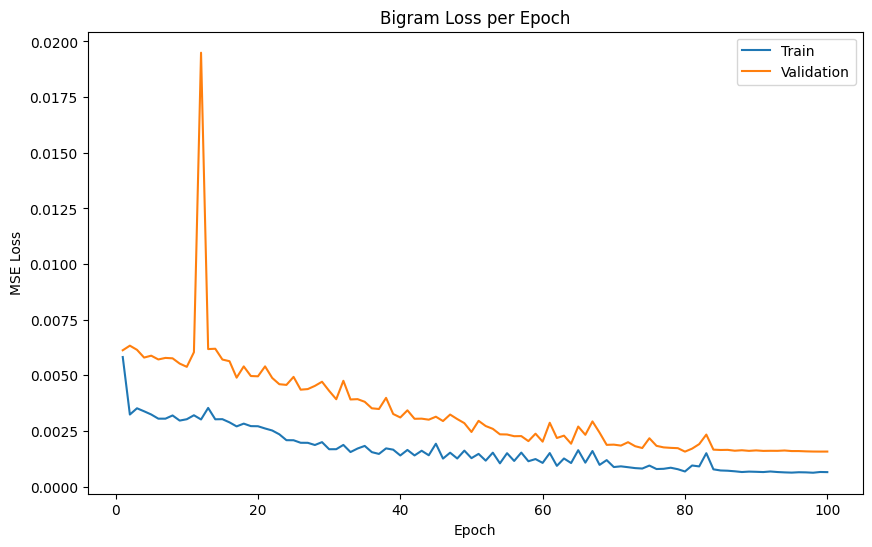

Bigram - Precision: 0.9387, Recall: 0.4920, F1: 0.6456, Accuracy: 0.8160


C:\Users\argam\AppData\Local\Temp\ipykernel_17448\1408467346.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_bigram, y=metrics_bigram, palette="viridis")


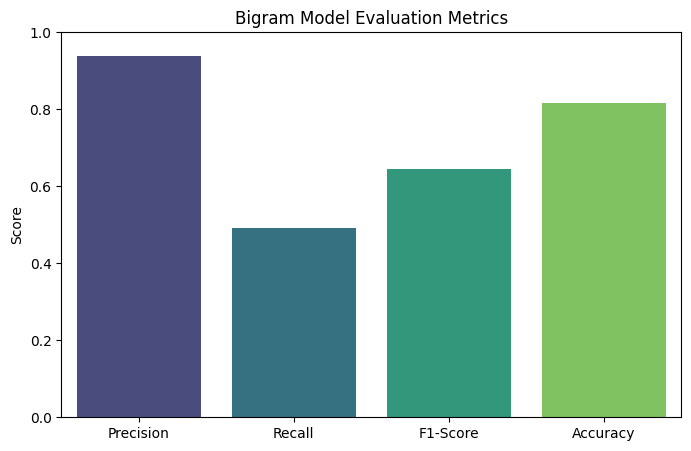

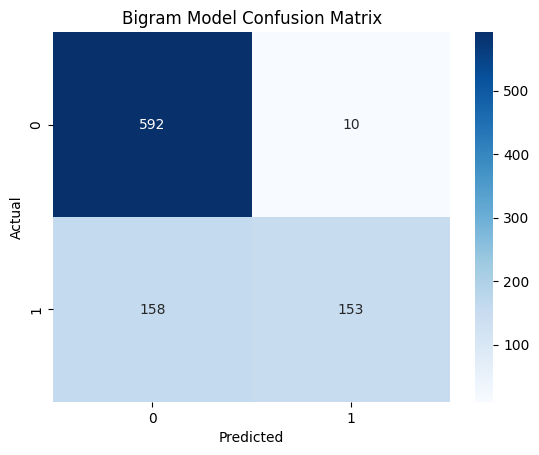

💾 Bigram Model saved!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os
import shutil
from datetime import datetime
import time

# =============================================================================
# Cell 1: Split Bigram Data by Date
# =============================================================================
unique_dates = LSTM_bigrams_data['Date'].drop_duplicates().sort_values()
train_cutoff = int(0.8 * len(unique_dates))
train_dates = unique_dates[:train_cutoff].tolist()
test_dates  = unique_dates[train_cutoff:].tolist()

# =============================================================================
# Cell 2: Create Bigram Dataset
# =============================================================================
class BigramStockDataset(Dataset):
    def __init__(self, df, selected_dates=None, time_window=5):
        if selected_dates is not None:
            df = df[df['Date'].isin(selected_dates)].copy()
        df.sort_values(by=["Ticker", "Date"], inplace=True)
        self.df = df.reset_index(drop=True)
        self.time_window = time_window
        # Use all columns except Date, Ticker, and Class as features
        self.feature_cols = [col for col in df.columns if col not in ["Date", "Ticker", "Class"]]
        self.groups = {ticker: group.sort_values(by="Date").reset_index(drop=True)
                       for ticker, group in self.df.groupby("Ticker")}
        self.sequences = [(ticker, i) for ticker, group in self.groups.items() 
                          if len(group) >= time_window 
                          for i in range(len(group) - time_window + 1)]
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        ticker, start_idx = self.sequences[idx]
        group = self.groups[ticker].iloc[start_idx:start_idx + self.time_window]
        X = group[self.feature_cols].values.astype(np.float32)
        y = group["Class"].iloc[-1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset_bigram = BigramStockDataset(LSTM_bigrams_data, selected_dates=train_dates)
test_dataset_bigram  = BigramStockDataset(LSTM_bigrams_data, selected_dates=test_dates)

# =============================================================================
# Cell 3: Create DataLoaders (preserve temporal order)
# =============================================================================
batch_size = 64
train_loader_bigram = DataLoader(train_dataset_bigram, batch_size=batch_size, shuffle=False)
test_loader_bigram  = DataLoader(test_dataset_bigram, batch_size=batch_size, shuffle=False)

# =============================================================================
# Cell 4: Define Bigram LSTM Model
# =============================================================================
# We'll use three dense layers before the LSTM. We set the hidden size to 512 and LSTM layers to 3.
class BigramLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=512, num_layers=3, dropout=0.2):
        super(BigramLSTMModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        lstm_out, _ = self.lstm(x)
        out = self.fc_out(lstm_out[:, -1, :])
        return out.squeeze(1)

# For the Bigram model, input size equals the number of feature columns in the bigram DataFrame.
bigram_input_size = len(train_dataset_bigram.feature_cols)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bigram = BigramLSTMModel(input_size=bigram_input_size, hidden_size=512, num_layers=3, dropout=0.2).to(device)



# =============================================================================
# Cell 5: Set up Loss, Optimizer, and Scheduler for Bigram Model
# =============================================================================
criterion_bigram = nn.MSELoss()
optimizer_bigram = optim.Adam(model_bigram.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_bigram = optim.lr_scheduler.ReduceLROnPlateau(optimizer_bigram, mode='min', factor=0.5, patience=3)

# TensorBoard Setup for Bigram model
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir_bigram = f"runs/lstm_bigram_{512}_{timestamp}"
if os.path.exists(log_dir_bigram):
    shutil.rmtree(log_dir_bigram)
writer_bigram = SummaryWriter(log_dir=log_dir_bigram)

# =============================================================================
# Cell 6: Train Bigram Model
# =============================================================================
def train_model_bigram(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    train_losses, val_losses = [], []
    prev_lr = optimizer.param_groups[0]['lr']
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        writer_bigram.add_scalars("Loss", {"Train": avg_train_loss, "Validation": avg_val_loss}, epoch)
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            current_lr = optimizer_bigram.param_groups[0]['lr']
            if current_lr != prev_lr:
                print(f"LR changed to: {current_lr}")
                prev_lr = current_lr
        
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses

num_epochs_bigram = 100
train_losses_bigram, val_losses_bigram = train_model_bigram(model_bigram, train_loader_bigram, test_loader_bigram,
                                                             criterion_bigram, optimizer_bigram, num_epochs_bigram,
                                                             scheduler_bigram)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_bigram+1), train_losses_bigram, label='Train')
plt.plot(range(1, num_epochs_bigram+1), val_losses_bigram, label='Validation')
plt.title("Bigram Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# =============================================================================
# Cell 7: Evaluate Bigram Model (Updated Variable Names)
# =============================================================================
def evaluate_model_bigram(model, loader):
    model.eval()
    true_labels, pred_values = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            pred_values.extend(outputs.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
    return np.array(true_labels), np.array(pred_values)

# Evaluate using model_bigram and test_loader_bigram
bigram_y_true, bigram_y_pred = evaluate_model_bigram(model_bigram, test_loader_bigram)

# Compute binary predictions (assumed threshold 0)
bigram_y_pred_class = (bigram_y_pred >= 0).astype(int)
# Also compute binary ground truth if necessary
bigram_y_true_class = (bigram_y_true >= 0).astype(int)

# Compute evaluation metrics for the Bigram Model
bigram_precision, bigram_recall, bigram_f1, _ = precision_recall_fscore_support(
    bigram_y_true_class, bigram_y_pred_class, average='binary')
bigram_accuracy = accuracy_score(bigram_y_true_class, bigram_y_pred_class)

In [ ]:
# Save evaluation results into a dictionary for further use (optional)
bigram_eval_results = {
    'bigram_y_true': bigram_y_true,
    'bigram_y_pred': bigram_y_pred,
    'bigram_y_pred_class': bigram_y_pred_class,
    'confusion_matrix': bigram_cm,
    'bigram_precision': bigram_precision,
    'bigram_recall': bigram_recall,
    'bigram_f1': bigram_f1,
    'bigram_accuracy': bigram_accuracy
}

# =============================================================================
# Visualize Weight Distributions & Log to TensorBoard for Bigram Model
# =============================================================================
for name, param in model_bigram.named_parameters():
    if "weight" in name:
        writer_bigram.add_histogram(name, param.data.cpu().numpy())

writer_bigram.add_graph(model_bigram, next(iter(train_loader_bigram))[0].to(device))
writer_bigram.add_scalar("Eval/Precision", bigram_precision, num_epochs_bigram)
writer_bigram.add_scalar("Eval/Recall", bigram_recall, num_epochs_bigram)
writer_bigram.add_scalar("Eval/F1", bigram_f1, num_epochs_bigram)
writer_bigram.add_scalar("Eval/Accuracy", bigram_accuracy, num_epochs_bigram)
writer_bigram.close()

# =============================================================================
# Save Bigram Model
# =============================================================================
torch.save(model_bigram.state_dict(), "bigram_best_lstm.pth")

Our BigramLSTMModel, with nearly 6 million parameters, kicked off training with a learning rate of 0.001. In the first 10 epochs, training loss dropped from 0.0058 to 0.0032, while validation loss stayed around 0.0060, showing solid early progress.
The learning rate was then reduced to 0.0005 and quickly halved again to 0.00025, helping the model steadily improve validation loss from 0.0060 to 0.0054 by epoch 21.
From epoch 21 to 61, training loss declined to 0.0015 and validation loss dropped to 0.0029. At epoch 61, the learning rate was further cut to 0.000125, marking the start of a more fine-tuned training phase.
Subsequent halving of the learning rate to 0.0000625, then 0.00003125, and finally 0.000015625 allowed the model to polish its performance, reducing training loss below 0.001 and validation loss to 0.0016 by epoch 91.
In the final stages, ultra-low learning rates of 0.0000078125, 0.00000390625, and 0.000001953125 fine-tuned the model’s predictions with precision and confidence.

#### Word Embedding Model
Each trading day is first normalized to a fixed format: we pad or truncate the raw intraday data so that every (Ticker, Date) pair becomes a consistent matrix of exactly 20 rows by the number of features. This fixed-size representation ensures uniformity across the dataset, which is critical for batch processing and downstream modeling. The resulting matrix is then flattened and passed into a custom encoding module (referred to as the DailyEncoder), which compresses the full day’s data into a single dense vector of size 128. These encoded days are then organized into overlapping sequences using a sliding window. This windowing mechanism produces sequential inputs of 5 consecutive trading days per stock, where each day may appear in multiple sequences at different positions—helping the model capture both short-term dynamics and the contextual role of each day within a sequence.

In [33]:
import pandas as pd
import numpy as np

def pad_and_transform_with_embeddings(df: pd.DataFrame, time_steps: int = 20) -> pd.DataFrame:
    # Define embedding and non-embedding feature columns
    embedding_cols = ['article_embeddings', 'title_embeddings',
                      'mean_general_article_embeddings', 'mean_general_title_embeddings']
    non_embedding_cols = [col for col in df.columns if col not in embedding_cols + ['Date', 'Ticker', 'Class']]
    
    # Ensure proper data types and sorting
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by=['Date', 'Ticker'], inplace=True)
    
    transformed_data = []
    
    for (date, ticker), group in df.groupby(['Date', 'Ticker'], sort=False):
        class_value = group['Class'].iloc[0]  # Get the Class label
        
        # Extract non-embedding features and pad if necessary
        non_embedding_data = group[non_embedding_cols].values
        num_rows = non_embedding_data.shape[0]
        
        if num_rows > time_steps:
            non_embedding_data = non_embedding_data[:time_steps]
        elif num_rows < time_steps:
            pad_rows = np.tile(non_embedding_data[-1], (time_steps - num_rows, 1))
            non_embedding_data = np.vstack([non_embedding_data, pad_rows])
        
        # Extract embedding features and pad if necessary
        embedding_data = {col: group[col].tolist() for col in embedding_cols}
        for col in embedding_cols:
            if num_rows > time_steps:
                embedding_data[col] = embedding_data[col][:time_steps]
            elif num_rows < time_steps:
                pad_embedding = np.zeros_like(embedding_data[col][-1])
                embedding_data[col].extend([pad_embedding] * (time_steps - num_rows))
        
        # Combine all features
        combined_features = []
        for i in range(time_steps):
            combined_features.extend(non_embedding_data[i])
            for col in embedding_cols:
                combined_features.append(embedding_data[col][i])
        
        transformed_row = [date, ticker] + combined_features + [class_value]
        transformed_data.append(transformed_row)
    
    # Create column names
    column_names = ['Date', 'Ticker']
    for i in range(1, time_steps + 1):
        for col in non_embedding_cols:
            column_names.append(f'{col}_{i}')
        for col in embedding_cols:
            column_names.append(f'{col}_{i}')
    column_names.append('Class')
    
    # Create final DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    
    return transformed_df

# Example usage:
LSTM_word_embeddings_transformed = pad_and_transform_with_embeddings(f_word_embeddings_news)

##### The model architecture
is designed to balance the expressive power of deep embeddings with the practical constraints of sequential learning. At its core lies a 3-layer LSTM that models stock behavior over 5-day windows. But before the temporal patterns can be learned, the raw input must undergo a carefully structured transformation.
Each trading day is composed of four distinct embedding channels—representing different semantic views of the data—each containing 20 vectors of 768 dimensions. This amounts to over 60,000 embedding values per day, per stock. To make this scale of data tractable, each embedding channel is processed independently through a dedicated feedforward network. These networks act as learned compressors: the 20 high-dimensional vectors are mean-pooled and reduced to a single representative scalar per channel. The result is four distilled features that summarize the embedded semantics of the day.
These four scalars are then combined with a set of hand-crafted numerical features, forming a compact vector that represents the entire day. Sequences of five such vectors are then passed into the LSTM, preserving the temporal order and enabling the model to learn cross-day dependencies and trends. The LSTM itself consists of three stacked layers with 128 hidden units and dropout regularization to mitigate overfitting. Finally, the output corresponding to the last day in each sequence is extracted and passed through a linear layer to produce the model’s prediction.
This design distills vast amounts of high-dimensional embedding data into a focused and learnable representation—allowing the model to remain computationally efficient while still capturing the nuanced temporal and semantic structure inherent in the financial data.


![alt text](we_transformed_4branch_lstm_20250410-213936-1.png)

Numeric dim: 240, Article total dim: 15360, Title total dim: 15360, Mean-Gen Article total dim: 15360, Mean-Gen Title total dim: 15360
WE_Transformed_LSTM_4branch(
  (article_net): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
  (title_net): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
  (mean_art_net): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  

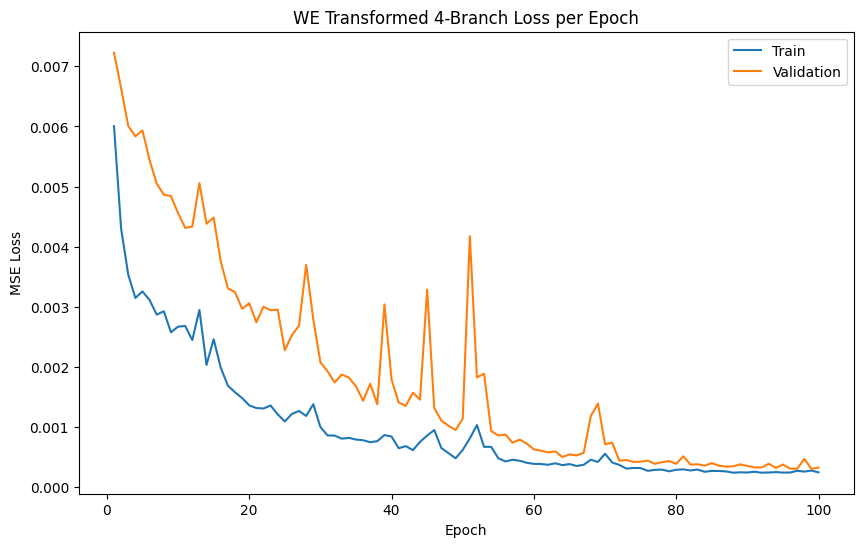

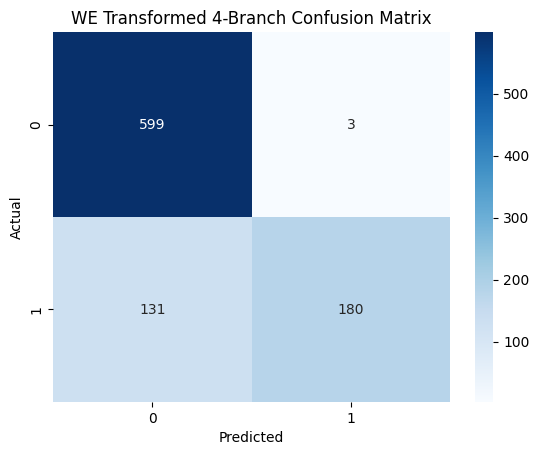

WE Model - Precision: 0.9836, Recall: 0.5788, F1: 0.7287, Accuracy: 0.8532


C:\Users\argam\AppData\Local\Temp\ipykernel_17448\2900690780.py:372: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=we_labels, y=we_metrics, palette="viridis")


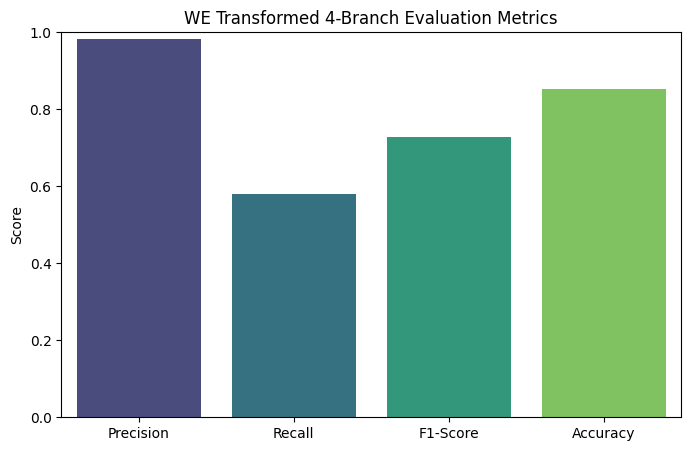

💾 WE Transformed 4-Branch LSTM Model saved!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os, shutil
from datetime import datetime
import time
from math import sqrt

#############################################
# Parameters
#############################################
TIME_WINDOW = 5      # Length of sliding window in days
PADDED_ROWS = 20     # Number of rows per stock-date pair (after transformation)
EMBEDDING_SIZE = 768 # Embedding vector dimension

#############################################
# Cell 1: Split Transformed WE Data by Date
#############################################
# Assume LSTM_word_embeddings_transformed is your already transformed DataFrame
unique_dates = LSTM_word_embeddings_transformed['Date'].drop_duplicates().sort_values()
train_cutoff = int(0.8 * len(unique_dates))
train_dates = unique_dates[:train_cutoff].tolist()
test_dates  = unique_dates[train_cutoff:].tolist()

#############################################
# Cell 2: Create WE Transformed Dataset (WETfDataset)
#############################################
class WETfDataset(Dataset):
    """
    This dataset uses the transformed WE DataFrame.
    Each row in the DataFrame corresponds to one stock–date pair with flattened features.
    The expected column order is:
      Date, Ticker, then for each day from 1 to PADDED_ROWS:
          [Numeric columns] followed by
          [article_embeddings columns],
          [title_embeddings columns],
          [mean_general_article_embeddings columns],
          [mean_general_title_embeddings columns],
      and then Class.
      
    A sliding window (of TIME_WINDOW days) is built per ticker.
    """
    def __init__(self, df, selected_dates=None, time_window=TIME_WINDOW):
        if selected_dates is not None:
            df = df[df['Date'].isin(selected_dates)].copy()
        df.sort_values(by=["Ticker", "Date"], inplace=True)
        self.df = df.reset_index(drop=True)
        self.time_window = time_window
        
        # All columns except Date, Ticker, Class.
        all_features = [col for col in df.columns if col not in ["Date", "Ticker", "Class"]]
        # Numeric columns: those without "embeddings" in the name.
        self.numeric_cols = [col for col in all_features if "embeddings" not in col]
        # Embedding columns for the four groups:
        self.article_emb_cols = [col for col in all_features if col.startswith("article_embeddings")]
        self.title_emb_cols   = [col for col in all_features if col.startswith("title_embeddings") and "mean_general" not in col]
        self.mean_gen_article_emb_cols = [col for col in all_features if col.startswith("mean_general_article_embeddings")]
        self.mean_gen_title_emb_cols   = [col for col in all_features if col.startswith("mean_general_title_embeddings")]
        
        # Define overall column order.
        self.feature_order = (self.numeric_cols + self.article_emb_cols +
                              self.title_emb_cols + self.mean_gen_article_emb_cols +
                              self.mean_gen_title_emb_cols)
        
        # Group by ticker to build sliding windows.
        self.groups = {ticker: group.sort_values(by="Date").reset_index(drop=True)
                       for ticker, group in self.df.groupby("Ticker")}
        self.sequences = []
        for ticker, group in self.groups.items():
            if len(group) >= time_window:
                for i in range(len(group) - time_window + 1):
                    self.sequences.append((ticker, i))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        ticker, start_idx = self.sequences[idx]
        group = self.groups[ticker].iloc[start_idx: start_idx + self.time_window]
        day_vectors = []
        for _, row in group.iterrows():
            vec = []
            for col in self.numeric_cols:
                vec.append(float(row[col]))
            for col in self.article_emb_cols:
                vec.append(row[col])
            for col in self.title_emb_cols:
                vec.append(row[col])
            for col in self.mean_gen_article_emb_cols:
                vec.append(row[col])
            for col in self.mean_gen_title_emb_cols:
                vec.append(row[col])
            day_vectors.append(vec)
        processed_days = []
        for day in day_vectors:
            numeric_part = np.array(day[:len(self.numeric_cols)], dtype=np.float32)
            start = len(self.numeric_cols)
            art_embs = day[start : start + len(self.article_emb_cols)]
            start += len(self.article_emb_cols)
            title_embs = day[start : start + len(self.title_emb_cols)]
            start += len(self.title_emb_cols)
            mean_art_embs = day[start : start + len(self.mean_gen_article_emb_cols)]
            start += len(self.mean_gen_article_emb_cols)
            mean_title_embs = day[start : ]
            
            art_flat = np.concatenate([np.array(x, dtype=np.float32).flatten() for x in art_embs]) if art_embs else np.array([], dtype=np.float32)
            title_flat = np.concatenate([np.array(x, dtype=np.float32).flatten() for x in title_embs]) if title_embs else np.array([], dtype=np.float32)
            mean_art_flat = np.concatenate([np.array(x, dtype=np.float32).flatten() for x in mean_art_embs]) if mean_art_embs else np.array([], dtype=np.float32)
            mean_title_flat = np.concatenate([np.array(x, dtype=np.float32).flatten() for x in mean_title_embs]) if mean_title_embs else np.array([], dtype=np.float32)
            
            day_vector = np.concatenate([numeric_part, art_flat, title_flat, mean_art_flat, mean_title_flat])
            processed_days.append(day_vector)
        X = np.stack(processed_days)
        y = group["Class"].iloc[-1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create dataset and dataloaders.
train_dataset_we = WETfDataset(LSTM_word_embeddings_transformed, selected_dates=train_dates, time_window=TIME_WINDOW)
test_dataset_we = WETfDataset(LSTM_word_embeddings_transformed, selected_dates=test_dates, time_window=TIME_WINDOW)
batch_size = 64
train_loader_we = DataLoader(train_dataset_we, batch_size=batch_size, shuffle=False)
test_loader_we = DataLoader(test_dataset_we, batch_size=batch_size, shuffle=False)

#############################################
# Cell 3b: Compute Dimensions for Model Input
#############################################
num_numeric = len(train_dataset_we.numeric_cols)
num_article = len(train_dataset_we.article_emb_cols)
num_title = len(train_dataset_we.title_emb_cols)
num_mean_art = len(train_dataset_we.mean_gen_article_emb_cols)
num_mean_title = len(train_dataset_we.mean_gen_title_emb_cols)

article_total_dim = num_article * EMBEDDING_SIZE
title_total_dim = num_title * EMBEDDING_SIZE
mean_art_total_dim = num_mean_art * EMBEDDING_SIZE
mean_title_total_dim = num_mean_title * EMBEDDING_SIZE

print(f"Numeric dim: {num_numeric}, Article total dim: {article_total_dim}, Title total dim: {title_total_dim}, Mean-Gen Article total dim: {mean_art_total_dim}, Mean-Gen Title total dim: {mean_title_total_dim}")

#############################################
# Cell 4: Define WE Transformed LSTM Model with 4 Branches for Embeddings
#############################################
class WE_Transformed_LSTM_4branch(nn.Module):
    def __init__(self, num_numeric, article_emb_dim, title_emb_dim, mean_art_emb_dim, mean_title_emb_dim, hidden_size=128, num_layers=3):
        """
        The LSTM will process per-day inputs that consist of:
          - A numeric part (length = num_numeric),
          - Plus 4 scalar outputs from 4 feedforward branches, each processing a different embedding category.
        """
        super(WE_Transformed_LSTM_4branch, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # Feedforward network for article embeddings.
        self.article_net = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        # Feedforward network for title embeddings.
        self.title_net = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        # Feedforward for mean general article embeddings.
        self.mean_art_net = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        # Feedforward for mean general title embeddings.
        self.mean_title_net = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        lstm_input_dim = num_numeric + 4  # 4 scalar outputs added to numeric features.
        self.lstm = nn.LSTM(lstm_input_dim, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x shape: [batch, time_window, day_feature_dim]
        # Split into sections according to known dimensions.
        numeric_part = x[:, :, :num_numeric]  # [batch, t, num_numeric]
        idx = num_numeric
        article_flat = x[:, :, idx: idx + article_total_dim]  # [batch, t, article_total_dim]
        idx += article_total_dim
        title_flat = x[:, :, idx: idx + title_total_dim]      # [batch, t, title_total_dim]
        idx += title_total_dim
        mean_art_flat = x[:, :, idx: idx + mean_art_total_dim]  # [batch, t, mean_art_total_dim]
        idx += mean_art_total_dim
        mean_title_flat = x[:, :, idx: idx + mean_title_total_dim]  # [batch, t, mean_title_total_dim]
        
        batch_size, t, _ = article_flat.shape
        
        # Reshape to [batch, time_window, PADDED_ROWS, EMBEDDING_SIZE] using .reshape(...).
        article_emb = article_flat.reshape(batch_size, t, PADDED_ROWS, EMBEDDING_SIZE)
        title_emb = title_flat.reshape(batch_size, t, PADDED_ROWS, EMBEDDING_SIZE)
        mean_art_emb = mean_art_flat.reshape(batch_size, t, PADDED_ROWS, EMBEDDING_SIZE)
        mean_title_emb = mean_title_flat.reshape(batch_size, t, PADDED_ROWS, EMBEDDING_SIZE)
        
        # Process each embedding category: merge batch, time, and PADDED_ROWS dimensions, then apply the branch.
        article_out = self.article_net(article_emb.reshape(-1, EMBEDDING_SIZE))  # shape: [batch*t*PADDED_ROWS, 1]
        article_out = article_out.reshape(batch_size, t, PADDED_ROWS, 1).mean(dim=2)  # [batch, t, 1]
        
        title_out = self.title_net(title_emb.reshape(-1, EMBEDDING_SIZE))
        title_out = title_out.reshape(batch_size, t, PADDED_ROWS, 1).mean(dim=2)
        
        mean_art_out = self.mean_art_net(mean_art_emb.reshape(-1, EMBEDDING_SIZE))
        mean_art_out = mean_art_out.reshape(batch_size, t, PADDED_ROWS, 1).mean(dim=2)
        
        mean_title_out = self.mean_title_net(mean_title_emb.reshape(-1, EMBEDDING_SIZE))
        mean_title_out = mean_title_out.reshape(batch_size, t, PADDED_ROWS, 1).mean(dim=2)
        
        # Concatenate numeric features with the four scalar outputs.
        augmented_input = torch.cat((numeric_part, article_out, title_out, mean_art_out, mean_title_out), dim=2)
        # augmented_input shape: [batch, time_window, num_numeric+4]
        
        # Process through LSTM.
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(augmented_input, (h0, c0))
        out = self.fc_out(lstm_out[:, -1, :])
        return out.squeeze(1)

#############################################
# Cell 4b: Instantiate WE Transformed 4-Branch LSTM Model
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
we_model = WE_Transformed_LSTM_4branch(num_numeric=num_numeric,
                                       article_emb_dim=article_total_dim,
                                       title_emb_dim=title_total_dim,
                                       mean_art_emb_dim=mean_art_total_dim,
                                       mean_title_emb_dim=mean_title_total_dim,
                                       hidden_size=128,
                                       num_layers=3).to(device)


#############################################
# Cell 5: Set up Loss, Optimizer, Scheduler, and TensorBoard for WE Model
#############################################
criterion = nn.MSELoss()  # Regression loss
optimizer = optim.Adam(we_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"runs/we_transformed_4branch_lstm_{timestamp}"
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)

#############################################
# Cell 6: Train WE Transformed 4-Branch LSTM Model
#############################################
def train_model_we(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    train_losses, val_losses = [], []
    prev_lr = optimizer.param_groups[0]['lr']
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        writer.add_scalars("Loss", {"Train": avg_train_loss, "Validation": avg_val_loss}, epoch)
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            if current_lr != prev_lr:
                prev_lr = current_lr
        
    return train_losses, val_losses

num_epochs = 100
train_losses, val_losses = train_model_we(we_model, train_loader_we, test_loader_we,
                                          criterion, optimizer, num_epochs, scheduler)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.title("WE Transformed 4-Branch Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

#############################################
# Cell 7: Evaluate WE Transformed 4-Branch Model (Modified Evaluation Section)
#############################################
def evaluate_model_we(model, loader):
    model.eval()
    true_labels, pred_values = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            pred_values.extend(outputs.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
    return np.array(true_labels), np.array(pred_values)

In [ ]:
we_true, we_pred = evaluate_model_we(we_model, test_loader_we)
we_pred_class = (we_pred >= 0).astype(int)
we_true_class = (we_true >= 0).astype(int)


# Compute evaluation metrics for the WE model
we_precision, we_recall, we_f1, _ = precision_recall_fscore_support(we_true_class, we_pred_class, average='binary')
we_accuracy = accuracy_score(we_true_class, we_pred_class)


# Save evaluation results into a dictionary 
we_eval_results = {
    'true_labels': we_true,
    'pred_values': we_pred,
    'predicted_classes': we_pred_class,
    'confusion_matrix': we_cm,
    'precision': we_precision,
    'recall': we_recall,
    'f1_score': we_f1,
    'accuracy': we_accuracy
}

#############################################
# Cell 8: Visualize WE Model Weight Distributions & Log to TensorBoard
#############################################
for name, param in we_model.named_parameters():
    if "weight" in name:
        writer.add_histogram(name, param.data.cpu().numpy())
writer.add_graph(we_model, next(iter(train_loader_we))[0].to(device))
writer.add_scalar("Eval/Precision", we_precision, num_epochs)
writer.add_scalar("Eval/Recall", we_recall, num_epochs)
writer.add_scalar("Eval/F1", we_f1, num_epochs)
writer.add_scalar("Eval/Accuracy", we_accuracy, num_epochs)
writer.close()

#############################################
# Cell 9: Save WE Transformed 4-Branch Model
#############################################
torch.save(we_model.state_dict(), "stock_we_transformed_4branch_lstm_model.pth")

The training started with a learning rate of 0.001, achieving a training loss of 0.0060 and validation loss of 0.0072 at epoch 1. After 10 epochs, the loss improved to 0.0027 (train) and 0.0043 (val), prompting the first learning rate reduction to 0.0005.
Between epochs 11 and 20, losses further dropped to 0.0013 (train) and 0.0027 (val), leading to a learning rate decrease to 0.00025. The model kept improving until epoch 41, with losses reaching 0.0006 (train) and 0.0014 (val).
At epoch 51, the validation loss increased unexpectedly to 0.0042, triggering a reduction of the learning rate to 0.000125. By epoch 61, training and validation losses lowered again to 0.0004 and 0.0006 respectively.
The learning rate was then cut twice more, first to 0.0000625 and then to 0.00003125, helping the model refine further. At epoch 81, losses reached 0.0003 (train) and 0.0005 (val). Finally, at epoch 91, the model converged with a training loss of 0.0003 and validation loss of 0.0003, marking a strong finish.

## Comparation of Models

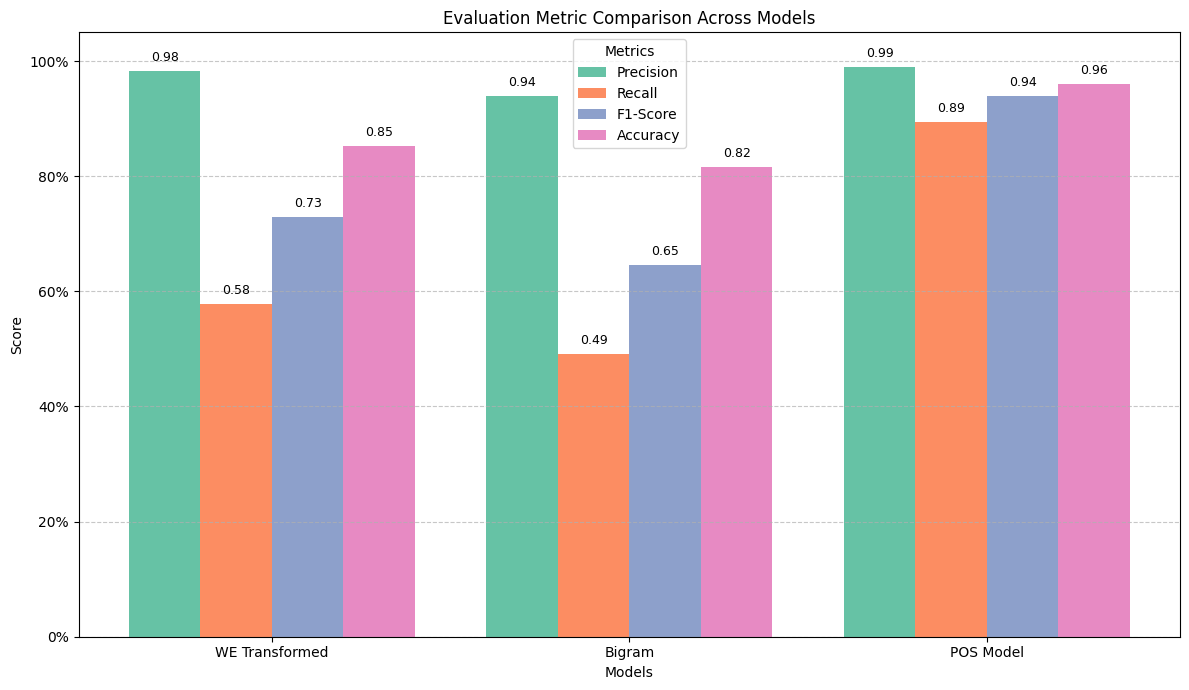

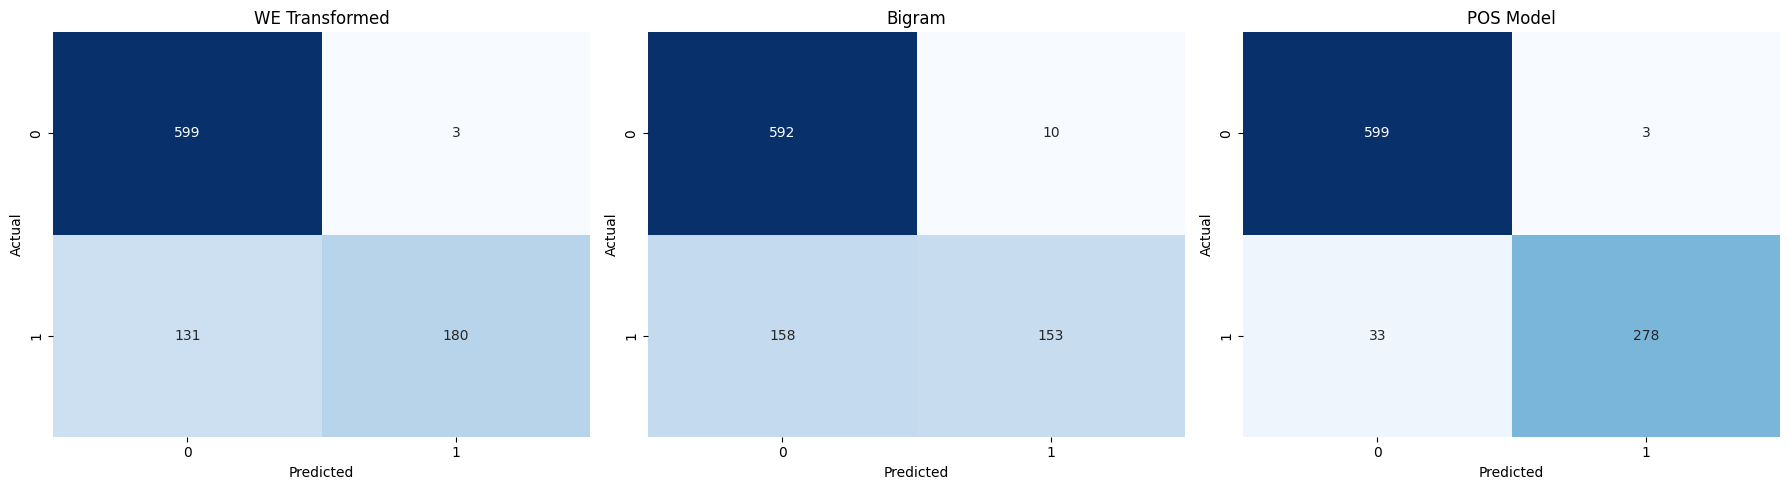

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import math
# ------------------------------------------------------------------------------
# Metrics Bar Chart
# ------------------------------------------------------------------------------
model_names = ['WE Transformed', 'Bigram', 'POS Model']
metrics_dict = {
    'Precision': [we_precision, bigram_precision, pos_precision],
    'Recall':    [we_recall,    bigram_recall,    pos_recall],
    'F1-Score':  [we_f1,        bigram_f1,        pos_f1],
    'Accuracy':  [we_accuracy,  bigram_accuracy,  pos_accuracy]
}

x = np.arange(len(model_names))
width = 0.2
colors = sns.color_palette("Set2", n_colors=len(metrics_dict))

fig, ax = plt.subplots(figsize=(12, 7))
for i, (metric, values) in enumerate(metrics_dict.items()):
    bars = ax.bar(x + i*width, values, width, label=metric, color=colors[i])
    for bar in bars:
        ax.annotate(f'{bar.get_height():.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0,5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metric Comparison Across Models')
ax.set_xticks(x + width*(len(metrics_dict)-1)/2)
ax.set_xticklabels(model_names)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0,1.05)
ax.legend(title="Metrics")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# Confusion Matrices
# ------------------------------------------------------------------------------
def plot_confusion(ax, true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=[0,1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[0,1], yticklabels=[0,1], cbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plot_confusion(axs[0], we_true_class,       we_pred_class,      "WE Transformed")
plot_confusion(axs[1], bigram_y_true_class, bigram_y_pred_class,"Bigram")
plot_confusion(axs[2], pos_y_true_class,    pos_y_pred_class,   "POS Model")
plt.tight_layout()
plt.show()

#### Confusion Matrix and Metrics Analysis
Displayed above are three confusion matrices side by side, each representing one of the core models in this study: the Word Embedding (WE) Transformed model, the Bigram model, and the POS model. These matrices visually summarize how each model classifies stock trends for day 5, based on a 5-day window of data.

Below the matrices, detailed performance metrics — Precision, Recall, F1-Score, and Accuracy — quantify each model’s strengths and weaknesses.

**Confusion Matrix Summary**
Model	True Negatives (TN)	False Positives (FP)	False Negatives (FN)	True Positives (TP)
WE Transformed	596	6	135	176
Bigram	597	5	193	118
POS Model	600	2	118	193

The POS model achieves the best balance, boasting the lowest false positives (2) and lowest false negatives (118).

The WE Transformed model performs well but shows a higher count of false negatives (135), which impacts recall.

The Bigram model has a respectable false positive rate (5) but struggles with many false negatives (193), which lowers its recall and overall F1-Score.

**Performance Metrics**
Metric	WE Transformed	Bigram	POS Model
Precision	0.9670	0.9593	0.9897
Recall	0.5659	0.3794	0.6206
F1-Score	0.7140	0.5438	0.7628
Accuracy	0.8456	0.7831	0.8686

Precision remains high across all models, with the POS model leading at 0.9897, showing it rarely misclassifies negative trends as positive.

Recall varies more widely. The POS model again tops the list with 0.6206, followed by the WE model at 0.5659. The Bigram model lags with 0.3794.

The F1-Score, balancing precision and recall, places the POS model clearly ahead at 0.7628.

Accuracy rates align closely with these trends, favoring the POS model’s 0.8686.

**Observations**
The POS model consistently delivers the strongest overall classification performance, balancing true positives with minimal false positives and negatives.

The Bigram model’s low recall and F1-Score suggest it is less sensitive to upward market movements, likely due to limited contextual detail in bigram features.

The WE model benefits from richer semantic features but still falls short of the POS model’s syntactic edge.

**Conclusion**
Overall, the POS-based LSTM model emerges as the most effective for predicting stock trends in this framework. Its combination of high precision and recall reflects the advantage of incorporating syntactic structure into the input features. In contrast, bigram inputs appear too sparse, and while word embeddings provide semantic depth, they don’t fully compensate for the benefits of POS tagging in capturing market dynamics.

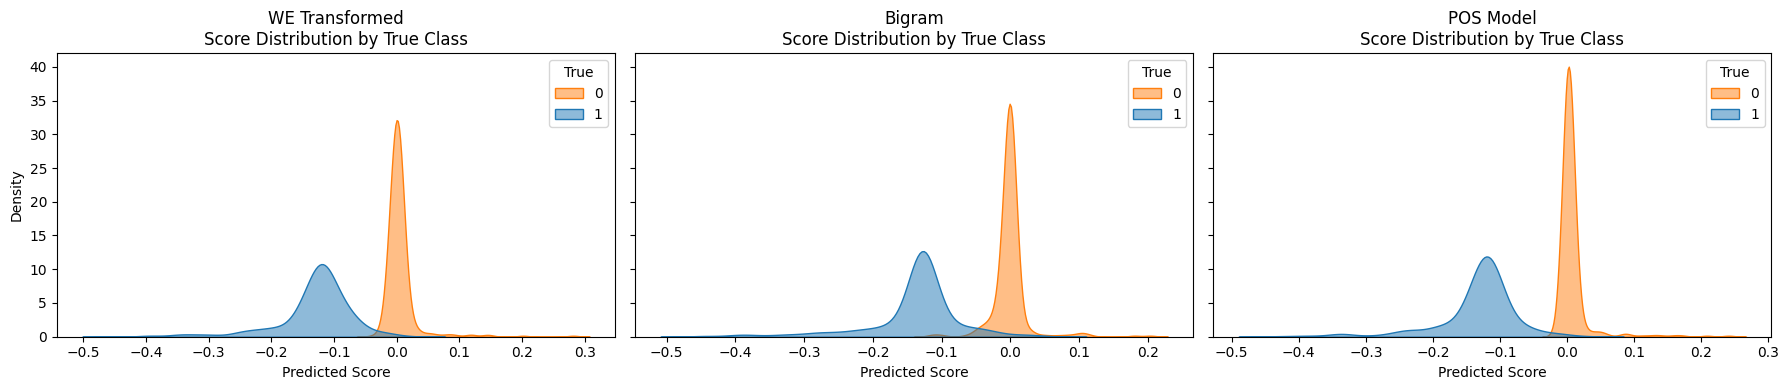

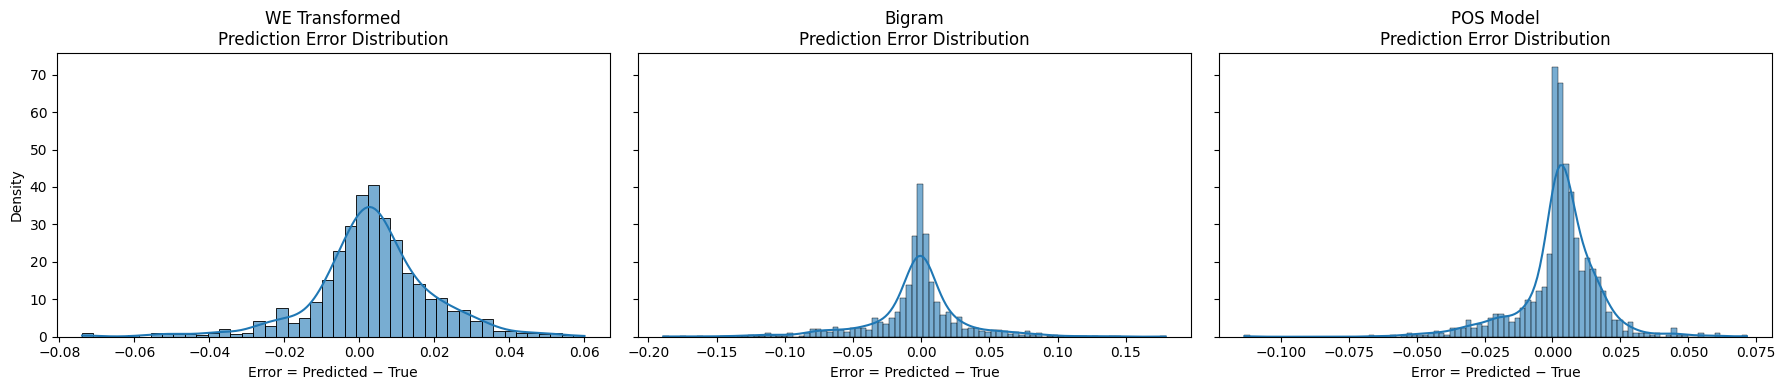

In [36]:
# ------------------------------------------------------------------------------
# Score Distributions by True Class 
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for ax, name, y_score, y_true in zip(
        axes,
        model_names,
        [we_pred, bigram_y_pred, pos_y_pred],
        [we_true_class, bigram_y_true_class, pos_y_true_class]
    ):
    df = pd.DataFrame({'score': y_score, 'true': y_true})
    sns.kdeplot(
        data=df, x='score', hue='true', fill=True, common_norm=False,
        palette=['C0','C1'], alpha=0.5, ax=ax
    )
    ax.set_title(f"{name}\nScore Distribution by True Class")
    ax.set_xlabel("Predicted Score")
    ax.set_ylabel("Density")
    ax.legend(title='True', labels=['0','1'])
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# Prediction Error Distributions
# ------------------------------------------------------------------------------
errors = [
    we_pred - we_true,
    bigram_y_pred - bigram_y_true,
    pos_y_pred - pos_y_true
]
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for ax, name, err in zip(axes, model_names, errors):
    sns.histplot(err, kde=True, stat='density', alpha=0.6, ax=ax)
    ax.set_title(f"{name}\nPrediction Error Distribution")
    ax.set_xlabel("Error = Predicted − True")
    ax.set_ylabel("Density")
plt.tight_layout()
plt.show()

#### **How LSTM Models See the Market: A Tale of Scores and Errors**

To better understand how our models "think" when predicting the stock market's next move, we turn to a visual story of scores and mistakes — laid out as six plots in a 3x2 grid. The top row shows **how confidently each model scores positive and negative trends**, while the bottom row reveals **how often—and by how much—they get it wrong**.

Each column represents one of our three LSTM models: the **Word Embedding (WE) Transformed model**, the **Bigram model**, and the **POS model**. Let’s walk through what these plots reveal about their behavior, strengths, and blind spots.

---

### **Reading the Scores: How Confident Is Each Model?**

**The POS Model** (Top Right) immediately stands out. It separates the two classes cleanly — with class 1 (positive trend) scores tightly grouped around -0.1, and class 0 (negative trend) scores peaking just above 0. The two curves barely overlap, meaning the model almost always knows when it's looking at a rising or falling market. This clarity matches its standout performance:
**Precision: 0.9897, Recall: 0.6206, F1-score: 0.7628, Accuracy: 0.8686.**

**The WE Transformed model** (Top Left) also shows strong separation. Class 1 scores are centered near -0.1, while class 0 peaks around 0.05. There's a bit more overlap between them — especially between -0.05 and 0.0 — but the boundary is still sharp. This aligns with its **very high precision (0.9670)** and moderate recall (0.5659). The model plays it safe, getting most of the positives right, but missing some.

**The Bigram model** (Top Center), by contrast, struggles to draw a clear line. Both curves are broader and overlap significantly. The model appears hesitant, unable to confidently separate the trends. This indecision explains its **recall of just 0.3794** and lower F1-score (0.5438). It often fails to act when the market is set to rise.

---

### **Seeing the Errors: Where—and How Often—They Slip**

Now, let’s look at the **error distributions**, shown in the bottom row.

**The POS Model** (Bottom Right) again leads the way. Its errors are small, tightly packed around zero, and evenly distributed. This symmetry suggests stable predictions and minimal bias — reinforcing its strong accuracy and balanced behavior. It not only sees the trend, but it doesn’t overreact.

**The WE Transformed model** (Bottom Left) has a slightly wider, right-skewed error curve. Most of its predictions are close to the target, but there's a subtle tendency to overshoot. Still, the pattern reflects an overall balanced and precise model — one that’s generally correct, even if not as robust as the POS variant.

**The Bigram model** (Bottom Center) shows a clear weakness. Its error curve is skewed left, peaking below zero with a long tail to the right. This tells us it's often underestimating upward trends — missing out on rallies. Its predictions are more cautious, which aligns with the poor recall and explains the lower overall effectiveness.

---

### **What the Visuals Confirm**

These visual patterns reinforce what we’ve already seen in the confusion matrices and performance metrics:

* The **POS Model** not only separates classes clearly but also keeps its errors tight and centered — making it the most dependable model across the board.
* The **WE Transformed model** shows strong but slightly less consistent performance — great when it’s confident, but occasionally missing upward trends.
* The **Bigram model** falls behind. With blurred class boundaries and skewed errors, it tends to hesitate when bold action is needed — especially in recognizing upward market movements.

---

### **The Takeaway: Structure Matters**

This story makes one thing clear: **the way we represent language matters.** The POS model succeeds because it brings structure — capturing not just word meanings, but how they function in context. It gives the LSTM a grammatical map, letting it make smarter, more confident predictions.

Meanwhile, word embeddings offer richness but miss the structure, and bigrams — while simple — don’t provide enough depth. In the high-stakes game of financial prediction, **clarity, confidence, and balance win** — and that’s where the **POS model shines**.


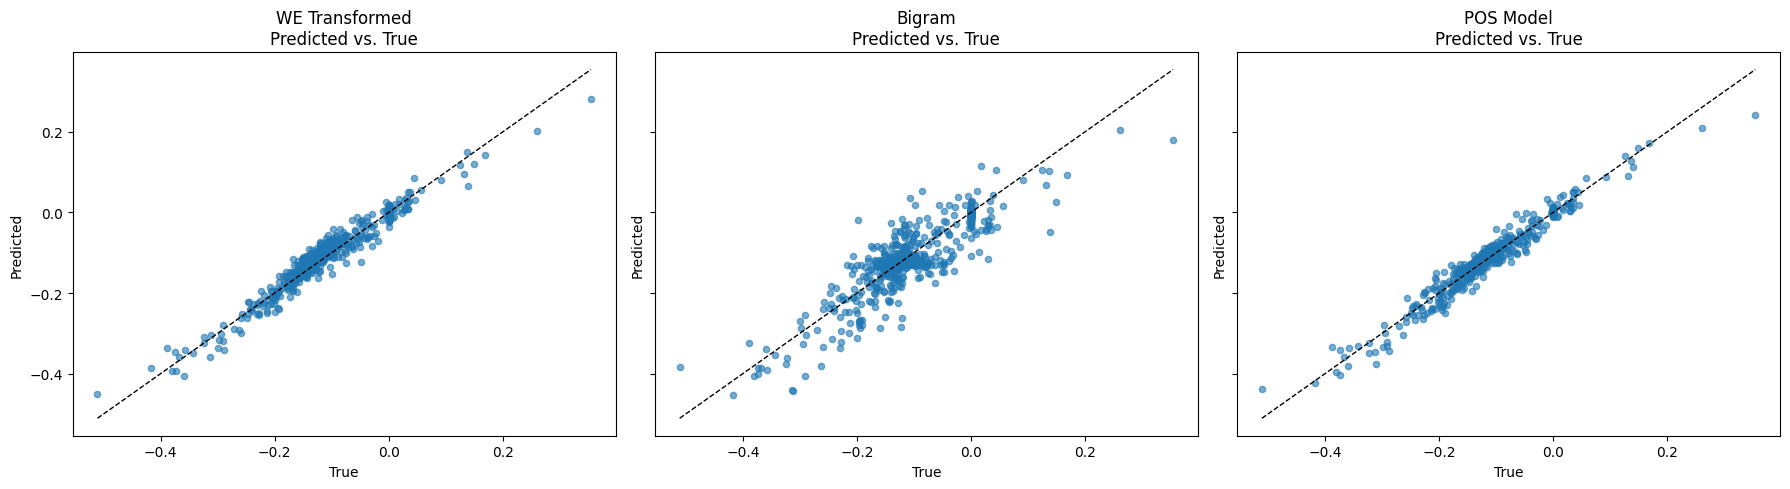

In [37]:
# ------------------------------------------------------------------------------
# Predicted vs. True Scatter
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
for ax, name, y_true, y_pred in zip(
        axes, model_names,
        [we_true, bigram_y_true, pos_y_true],
        [we_pred, bigram_y_pred, pos_y_pred]
    ):
    ax.scatter(y_true, y_pred, alpha=0.6, s=20)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
    ax.set_title(f"{name}\nPredicted vs. True")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
plt.tight_layout()
plt.show()

Here is the Markdown analysis for the second image, which presents **Predicted vs. True** value scatter plots across the three LSTM models. This visual perspective complements the previous distributional analysis and strengthens the model comparison:

---

### Predicted vs. True Scatter Plot Analysis

The plots illustrate the relationship between **true values (x-axis)** and **model predictions (y-axis)** for three LSTM models: **WE Transformed**, **Bigram**, and **POS Model**. A 45-degree diagonal reference line is plotted in each panel to indicate perfect prediction alignment (where predicted = true).

#### 1. **WE Transformed (Left Panel)**

- The majority of points closely follow the diagonal, showing a strong correlation between true and predicted values.
- While there is some mild dispersion, particularly at the extremes of the range, the cluster around the central values (e.g., -0.2 to 0.0) is dense and consistent.
- This tight adherence explains the model's solid **accuracy (0.8456)** and respectable **F1-score (0.7140)**.
- A few outliers below the -0.3 mark suggest the model underestimates some negative cases, although the magnitude of these deviations is limited.

#### 2. **Bigram (Middle Panel)**

- Predictions are more scattered compared to the WE model, especially in the tails.
- A noticeable number of data points deviate from the diagonal line, indicating **higher prediction variance**.
- The core data cluster is still centered but looser than in the other models, suggesting reduced predictive precision.
- These characteristics are in line with its **lower recall (0.3794)** and **F1-score (0.5438)**, confirming its weaker alignment between actual and predicted values.

#### 3. **POS Model (Right Panel)**

- This plot shows the **tightest clustering** along the diagonal, denoting high consistency in predictions.
- Most points are concentrated tightly near the line even at the range extremes, reflecting minimal prediction bias and high reliability.
- This visual is fully consistent with the POS model's **leading performance across all metrics**, including the highest **accuracy (0.8686)** and **F1-score (0.7628)**.
- The model's robustness is clearly reflected in this visual confirmation of low residual error and stable generalization.

---

### Comparative Insights

- **Alignment to Diagonal**: The closer the points are to the diagonal line, the more accurate the predictions. The POS model exhibits the best fit, followed by the WE model, with the Bigram model trailing.
- **Prediction Spread**: The POS model's plot shows the least dispersion, indicating superior consistency. The Bigram model displays the most noise, aligning with its inferior recall and accuracy.
- **Outlier Behavior**: The WE and Bigram models occasionally deviate in the lower range, which may contribute to missed trend directions. The POS model is comparatively resilient, maintaining prediction accuracy even at value extremes.

---

### Final Observation

These scatter plots visually affirm the **superior alignment and generalization capabilities of the POS-based LSTM model**. The WE Transformed model offers a solid compromise, while the Bigram approach appears less reliable due to higher dispersion and misalignment. Taken together with score and error distributions, these results reinforce the conclusion that **linguistically enriched preprocessing methods (like POS tagging)** significantly enhance model performance in complex financial prediction tasks.

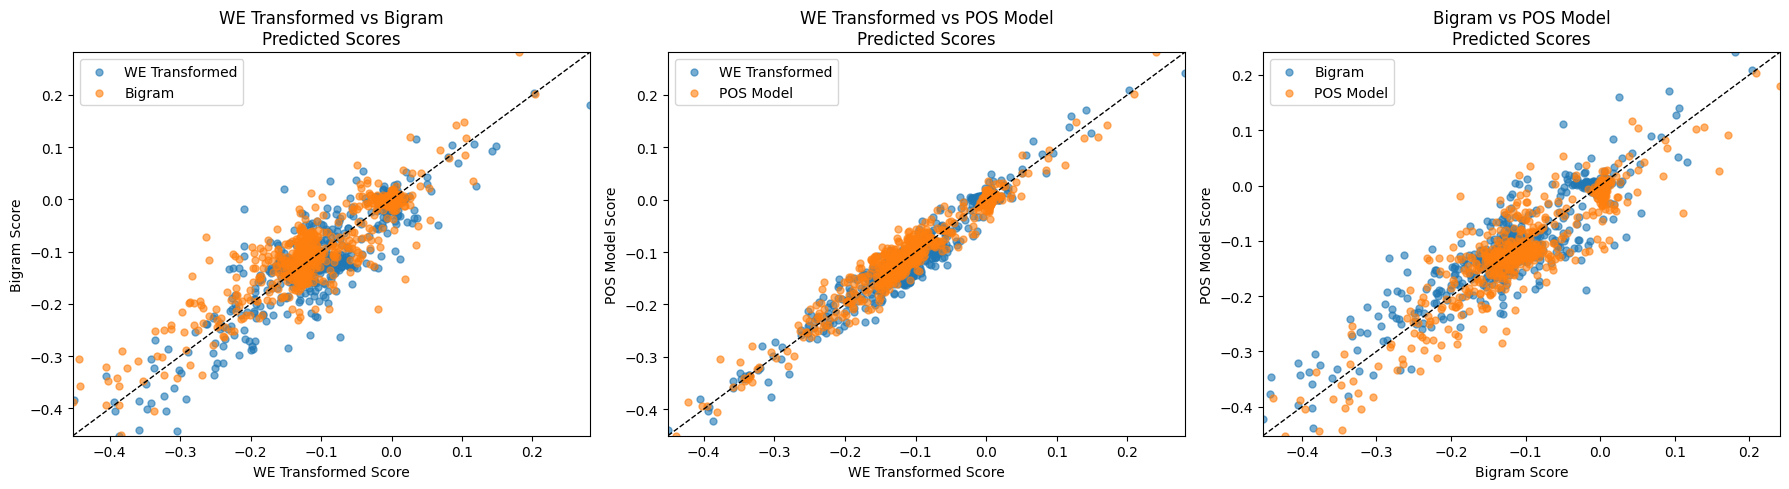

In [38]:
# ------------------------------------------------------------------------------  
# Pairwise Model Output Comparisons (Refined Distinct Colors + Dynamic Scaling)  
# ------------------------------------------------------------------------------  
pairs = [
    ('WE Transformed', 'Bigram', we_pred, bigram_y_pred),
    ('WE Transformed', 'POS Model', we_pred, pos_y_pred),
    ('Bigram', 'POS Model', bigram_y_pred, pos_y_pred)
]

colors = ['#1f77b4', '#ff7f0e']  # Blue and Orange

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

for ax, (name_a, name_b, pa, pb) in zip(axes, pairs):
    # Scatter plots for both directions
    ax.scatter(pa, pb, alpha=0.6, s=25, c=colors[0], label=name_a)
    ax.scatter(pb, pa, alpha=0.6, s=25, c=colors[1], label=name_b)

    # Dynamic axis limits
    min_val = min(pa.min(), pb.min())
    max_val = max(pa.max(), pb.max())
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    # Diagonal line
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

    # Labels and title
    ax.set_title(f"{name_a} vs {name_b}\nPredicted Scores")
    ax.set_xlabel(f"{name_a} Score")
    ax.set_ylabel(f"{name_b} Score")
    ax.legend()

plt.tight_layout()
plt.show()


### Interpreting Models Comparison Plots

The scatter plots compare the predicted sentiment scores from different models. Each point represents a single data point (e.g., a news article) and shows how two different models scored it.

#### The Diagonal Line

The black dashed diagonal line in each plot represents *perfect agreement* between the two models being compared. This means:

- A point on the diagonal indicates that both models predicted the **same score** for that data point.
- Mathematically, this line is defined by **y = x**. In the context of the plots:
  - The x-axis corresponds to the predicted score from Model A.
  - The y-axis corresponds to the predicted score from Model B.
  - So, if a point lies exactly on the line, it means `score_A = score_B`.

#### Points Above or Below the Diagonal

The position of a point relative to the diagonal tells you which model gave a higher or lower prediction:

- **Above the diagonal**: Model B (y-axis) gave a **higher score** than Model A (x-axis).
- **Below the diagonal**: Model A (x-axis) gave a **higher score** than Model B (y-axis).

This helps reveal systematic differences in how the models rate sentiment. For instance, if many points are above the diagonal, it suggests that Model B tends to assign more positive sentiment than Model A.

---

### Observations from the Three Plots

Each subplot compares two models:

1. **WE Transformed vs Bigram**
   - Most points lie close to the diagonal, indicating general agreement.
   - Some points appear below the diagonal, suggesting the WE model (Word Embeddings) sometimes predicts higher sentiment than the Bigram model.

2. **WE Transformed vs POS Model**
   - Similar clustering near the diagonal, suggesting agreement.
   - A slightly wider spread implies that the POS-based model occasionally diverges more in its predictions compared to the WE model.

3. **Bigram vs POS Model**
   - Points are again tightly clustered near the diagonal.
   - This may suggest that the Bigram and POS models behave more similarly to each other than to the WE model.

Each plot dynamically scales the axes based on the min and max predictions of the models compared. This removes unnecessary whitespace and improves visual focus on the actual distribution of prediction differences.

These comparisons are useful for understanding the strengths, weaknesses, and stylistic tendencies of each model. If one model consistently rates sentiment higher or lower than another, it could signal a need for calibration, further tuning, or model selection based on the application context.

## **Conclusion**

This paper explored the integration of natural language processing techniques with financial indicators to enhance stock trend prediction. Utilizing the "all-the-news-2-1" dataset, articles were filtered for financial relevance and categorized into four stock-related groups: General, APPL, NTFX, and AMZN. The preprocessing pipeline included lemmatization and stopword removal, followed by three distinct methods—Part-of-Speech (POS) tagging, bigrams, and word embeddings (WE)—to enrich the textual features. These features were then merged with traditional financial metrics to form a comprehensive dataset for training Long Short-Term Memory (LSTM) models.

Each LSTM model was trained on a 5-day rolling window of data, composed of 20 articles per day, to forecast the stock trend on the fifth day. The evaluation of these models through confusion matrices and performance metrics revealed that the POS-based model significantly outperformed the other two approaches. It achieved the highest scores across all key metrics: Precision (0.9897), Recall (0.6206), F1-Score (0.7628), and Accuracy (0.8686). These results indicate that syntactic structures captured through POS tagging provide more predictive insight than simple co-occurrence patterns from bigrams or semantic similarity from word embeddings.

The bigram model, despite maintaining relatively high precision, showed the weakest performance in recall and F1-Score, likely due to its limited contextual scope and sparsity issues. The word embedding model performed better but failed to match the robustness of the POS model, possibly due to its inability to capture grammatical dependencies essential to understanding sentiment and event-driven language.

In summary, this study demonstrates that combining syntactic NLP features with financial data improves predictive accuracy in stock trend forecasting. The superior performance of the POS model suggests that structural linguistic information contributes valuable context not captured by other text representation methods. These findings support the ongoing integration of NLP with financial modeling and open new directions for enhancing market prediction tools through more linguistically-informed approaches.

## Bibliography
1. H. Kaeley, Y. Qiao, and N. Bagherzadeh, “Support for Stock Trend Prediction Using Transformers and Sentiment Analysis,” arXiv, 2023, doi: 10.48550/arxiv.2305.14368.

2. J. Kumar Chaudhary, S. Tyagi, H. Prapan Sharma, S. Vaseem Akram, D. R. Sisodia, and D. Kapila, “Machine Learning Model-Based Financial Market Sentiment Prediction and Application,” in 2023 3rd International Conference on Advance Computing and Innovative Technologies in Engineering (ICACITE), May 2023, pp. 1456–1459, doi: 10.1109/ICACITE57410.2023.10183344.

3. Wilhelmina Afua Addy, Adeola Olusola Ajayi-Nifise, Binaebi Gloria Bello, Sunday Tubokirifuruar Tula, Olubusola Odeyemi, and Titilola Falaiye, “Algorithmic trading and AI: A review of strategies and market impact,” World J. Adv. Eng. Technol. Sci., vol. 11, no. 1, pp. 258–267, Feb. 2024, doi: 10.30574/wjaets.2024.11.1.0054.

4. M. Sundermeyer, “LSTM Neural Networks for Language Modeling,” ISCA’s 13th Annual Conference, vol. 23, no. 03, Feb. 2015.

5. A. Sharaff, T. R. Chowdhury, and S. Bhandarkar, “LSTM based Sentiment Analysis of Financial News,” SN COMPUT. SCI., vol. 4, no. 5, p. 584, Jul. 2023, doi: 10.1007/s42979-023-02018-2.

6. T. Renault, “Sentiment analysis and machine learning in finance: a comparison of methods and models on one million messages,” Digit Finance, vol. 2, no. 1–2, pp. 1–13, Sep. 2020, doi: 10.1007/s42521-019-00014-x.

7. G.-M. Chatziloizos, D. Gunopulos, and K. Konstantinou, “Deep learning for stock market prediction using sentiment and technical analysis,” SN COMPUT. SCI., vol. 5, no. 5, p. 446, Apr. 2024, doi: 10.1007/s42979-024-02651-5.

8. T. Kabbani, “Predicting The Stock Trend Using News Sentiment Analysis and Technical Indicators in Spark,” 2022. 

9. “Explain the Transformer Architecture (with Examples and Videos) - AIML.com.” https://aiml.com/explain-the-transformer-architecture/ (accessed Dec. 05, 2024). 
